In [1]:




#导入torch，用于构建神经网络

import torch
from torch import nn


import numpy as np
import pandas as pd

#记录时间
from datetime import datetime

import time


import matplotlib.pyplot as plt

from scipy.interpolate import griddata
import scipy.io


#用于重复独立实验的随机种子
import random


#获取当前文件的名称

import os



plt.rcParams['figure.dpi'] =200



#设置随机种子
def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cuda.matmul.allow_tf32 = False# 尝试禁用这两个数据类型
        torch.backends.cudnn.allow_tf32 = False
        #torch.backends.cudnn.deterministic = True
        #torch.backends.cudnn.benchmark = False

        



        
def sample(min,max, N):

    x = min + (max - min) * torch.rand((N, 1), dtype = datadtype).to(device).requires_grad_(True)
   
    return x



# %%

class Net(nn.Module):
    def __init__(self,datadtype,layers):
        super().__init__()
        self.dtype = datadtype

        self.layers = layers

     
        # #定义傅里叶特征的系数
 
        self.W_t = nn.Parameter(torch.randn(1,self.layers[0]//2,
                                            dtype = self.dtype)*sigma_t,requires_grad = False)
        
        self.W_x = nn.Parameter(torch.randn(1,layers[0]//2,
                                            dtype = self.dtype)*sigma_x,requires_grad = False)

        self.weights, self.biases = self.initialize_NN(self.layers)

    def xavier_init(self,size):
        in_dim = size[0]
        out_dim = size[1]
        #创建一个需要Xavier初始化的张量
        tensor = torch.empty(in_dim, out_dim, dtype = self.dtype)
        #使用PyTorch的Xavier正态初始化
        nn.init.xavier_normal_(tensor)
        return tensor
    
    def initialize_NN(self, layers):
        weights = nn.ParameterList()
        biases = nn.ParameterList()

        num_layers = len(layers)
        for l in range(0, num_layers -2):
            W = self.xavier_init(size = [layers[l], layers[l+1]])
            b = nn.Parameter(torch.randn(1, layers[l+1],dtype = self.dtype))

            weights.append(W)
            biases.append(b)

        W = self.xavier_init(size = [layers[-2], layers[-1]])
        b = nn.Parameter(torch.randn(1, layers[-1], dtype = self.dtype))
        weights.append(W)
        biases.append(b)

        return weights, biases
    
    def forward(self,t,x):
        num_layers = len(self.layers)
        # #对输入进行归一化
        # t = 2.0*(t - t_lb)/(t_ub - t_lb) - 1.0
        # x = 2.0*(x - x_min)/(x_max - x_min) - 1.0

        #Temporal Fourier feature encoding
        H_t = torch.cat([torch.sin(torch.matmul(t, self.W_t)),
                         torch.cos(torch.matmul(t, self.W_t))], dim = 1)
        
        #Spatial Fourier feature encoding
        H_x = torch.cat([torch.sin(torch.matmul(x, self.W_x)),
                         torch.cos(torch.matmul(x, self.W_x))], dim = 1)
        
        #Pass through a MLP
        for l in range(0, num_layers -2):
            W = self.weights[l]
            b = self.biases[l]
            H_t = torch.tanh(torch.add(torch.matmul(H_t, W), b))
            H_x = torch.tanh(torch.add(torch.matmul(H_x, W), b))

        #Merge the outputs via points-wise multiplication
        H = H_t * H_x

        W = self.weights[-1]
        b = self.biases[-1]
        H = torch.add(torch.matmul(H, W), b)
        return H



# %%


# %%

class HCPINN(nn.Module):
    def __init__(self,mydtype, layers,  t_min,t_max):
        
        super(HCPINN, self).__init__()
        self.dtype = mydtype
        self.layers = layers

        self.t_min = t_min
        self.t_max = t_max



   
        #采点
        self.N_i = 1200
        self.N_b = int(1200 * (self.t_max - self.t_min))
        self.N_r = int(1e4 * (self.t_max - self.t_min))
        self.eta = 0.6 #定义重采样率
        self.N_n = int(self.N_r * self.eta)
        
        self.t_ics_batch =  sample(self.t_min,self.t_min, self.N_i)
        self.x_ics_batch =  sample(x_min,x_max, self.N_i)
       

        
        self.t_bc1_batch =  sample(self.t_min,self.t_max, self.N_b)
        self.x_bc1_batch =  sample(x_min,x_min, self.N_b)
        


        
        self.x_bc2_batch =  sample(x_max,x_max, self.N_b)
        


        #Fetch residual mini-bathes
        
        self.t_res_batch =  sample(self.t_min,self.t_max, self.N_r)
        self.x_res_batch =  sample(x_min,x_max, self.N_r)
       

        self.u_ics_batch = initial(self.x_ics_batch)


        #定义优化器
        self.net = Net(self.dtype, self.layers).to(device)
        self.iter = 0
        self.adam = torch.optim.Adam(self.parameters(), lr = 1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.adam, step_size = 1000, gamma= 0.9)
        self.optimizer = torch.optim.LBFGS(
            self.parameters(),
            lr = 1.0,
            max_iter = 10000,
            max_eval = 50000,
            history_size = 200,
            tolerance_grad = 1e-12,
            tolerance_change = 1.0 * np.finfo(float).eps,
            line_search_fn = 'strong_wolfe'
        )




    
  
    
    def net_u(self, t,x):
        u = self.net(t,x)
        return u
    
    def net_r(self, t, x):

     
        u = self.net_u(t,x)
       

        u_t = torch.autograd.grad(u, t,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph= True,
                                  retain_graph=True)[0]
        
        u_x = torch.autograd.grad(u, x,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph= True,
                                  retain_graph=True)[0]

       
        residual =  u_t + conv * u_x                              
        return residual
    

    
    def closure(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()



        #Evaluate predictions
        
      
        self.u_ics_pred = self.net_u(self.t_ics_batch, self.x_ics_batch)
        self.u_bc1_pred = self.net_u(self.t_bc1_batch, self.x_bc1_batch)
        self.u_bc2_pred = self.net_u(self.t_bc1_batch, self.x_bc2_batch)
     
     
        self.r_pred = self.net_r(self.t_res_batch, self.x_res_batch)

        #Boundary loss and Initial loss
        self.loss_ic = torch.mean((self.u_ics_pred- self.u_ics_batch)**2 )

        self.loss_ics = self.loss_ic


        self.loss_bc1 = torch.mean((self.u_bc1_pred - self.u_bc2_pred)**2 )
        

        self.loss_bcs =  self.loss_bc1
        

        #Residual loss
        self.loss_res = torch.mean((self.r_pred)**2 )

        #Total loss
        self.loss = self.loss_ics + self.loss_bcs + self.loss_res 

        self.loss.backward(retain_graph=True)
        

        self.iter += 1

        



        if self.iter % 1000 == 0:
            print(f'\r{self.iter},loss:{self.loss.item():.5e},i:{self.loss_ics.item():.2e},f:{self.loss_res.item():.2e},b:{self.loss_bcs.item():.2e}')
            if self.iter < nIter:
            
                x_new_train = sample(x_min,x_max, self.N_n)

                # 生成随机索引
                shuffle_indices = torch.randperm(self.N_r, device = device)

                # 打乱张量顺序
                self.x_res_batch = self.x_res_batch[shuffle_indices]

                self.x_res_batch[0:self.N_n] = x_new_train

        # if self.iter < nIter and self.iter % 1000 == 0:
                
        #         shuffle_indices = torch.randperm(N_r, device = device)

        #         x_new_train = sample(x_min,x_max, N_n)

        #         # 打乱张量顺序
        #         self.x_res_batch = self.x_res_batch[shuffle_indices]

        #         self.x_res_batch[0:N_n] = x_new_train

        #         t_new_train = sample(self.t_min,self.t_max, N_n)

        #         # 打乱张量顺序
        #         self.t_res_batch = self.t_res_batch[shuffle_indices]

        #         self.t_res_batch[0:N_n] = t_new_train


        return self.loss
    
    def predict_u(self,X):
        t = X[:,0:1]
        x = X[:,1:2]
        #模型进入评估状态
        self.eval()
        with torch.no_grad():
            u = self.net_u(t,x).detach()
 
        return u
    




In [2]:


class HCPINN_next(nn.Module):
    def __init__(self,mydtype, layers,t_min,t_max, premodel):
        
        super(HCPINN_next, self).__init__()
        

        self.premodel = premodel
        self.dtype = mydtype

        self.t_min = t_min
        self.t_max = t_max

        #停止第一个网络参数的训练
        for param in self.premodel.net.parameters():
            param.requires_grad = False

      

 

        #Initialize network weights and biases
        self.layers = layers
      

        

        
        
        #采点
        self.N_i = 100
        self.N_b = int( 1200 * (self.t_max - self.t_min))
        self.N_r = int( 1e4 * (self.t_max - self.t_min))
        self.eta = 0.6
        self.N_n = int(self.N_r * self.eta)


       
        self.t_ics_batch =  sample(self.t_min,self.t_min, self.N_i)
        self.x_ics_batch =  sample(x_min,x_max, self.N_i)
        

        
        self.t_bc1_batch =  sample(self.t_min,self.t_max, self.N_b)
        self.x_bc1_batch =  sample(x_min,x_min, self.N_b)
       

        self.x_bc2_batch =  sample(x_max,x_max, self.N_b)
        

        #Fetch residual mini-bathes
        
        self.t_res_batch =  sample(self.t_min,self.t_max, self.N_r)
        self.x_res_batch =  sample(x_min,x_max, self.N_r)

        

        
        self.u_ics_batch = self.premodel.net_u(self.t_ics_batch, self.x_ics_batch)


   


        #将分段函数加入训练
        self.breakpoint_log = []
        

        self.breakpoint_lb = self.t_min.item()
        self.breakpoint_ub = self.t_max.item()
    
        self.breakpoint = nn.Parameter(self.t_min+(self.t_max-self.t_min)*0.5)
        print("p的初始化：%.3e "%self.breakpoint.item())


        #定义优化器
        self.iter = 0
        self.net = Net(self.dtype, self.layers).to(device)

        self.adam = torch.optim.Adam(self.parameters(), lr = 1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.adam, step_size= 1000, gamma= 0.9)
        self.optimizer = torch.optim.LBFGS(
            self.parameters(),#间断点在LBFGS的阶段也训练
            lr = 1.0,
            max_iter = 10000,
            max_eval = 50000,
            history_size = 200,
            tolerance_grad = 1e-12,
            tolerance_change = 1.0 * np.finfo(float).eps,
            line_search_fn = 'strong_wolfe'
        )


        # # #加载上一个网络的信息
        # self.pretrained_dict = self.premodel.net.state_dict()
        # model_dict = self.net.state_dict()
        # model_dict.update(self.pretrained_dict)
        # self.net.load_state_dict(model_dict)
        # self.net.state_dict()


    def control_fun(self,t):
        ab = self.breakpoint
        # 条件1: t <= self.t_min
        condition2 = t <= self.t_min
        # 条件3: t <= ab
        condition3 = t <= ab
        # 条件4: ab <=self.t_end
        condition4 = ab <= self.t_max

        # 计算 B 和 BB
        A = 2 * (t - self.t_min)
        AA = A**2
        B = (t - self.t_min) / (ab - self.t_min)
        BB = B**2

        # 定义分段函数
        result = torch.where(condition2, torch.zeros_like(t),
                        torch.where(condition4, 
                                    torch.where(condition3, -2 * B*BB + 3 * BB, torch.zeros_like(t) + 1),
                                    -2 * A*AA + 3 * AA))
        return result
    


    def net_u(self, t,x):
        
        weight1 = self.control_fun(t)
        u = ( 1-weight1)*self.premodel.net(t,x) + weight1 * self.net(t,x)
        return u
    
    def net_r(self, t, x):

        u = self.net_u(t,x)

        u_t = torch.autograd.grad(u, t,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph= True,
                                  retain_graph=True)[0]
        
        u_x = torch.autograd.grad(u, x,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph= True,
                                  retain_graph=True)[0]

    

        residual = u_t + conv * u_x            

                             
        return residual
    

    
    def closure(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()



        self.breakpoint.data.clamp_(min = self.breakpoint_lb + 1e-6,max= (self.breakpoint_lb+(self.breakpoint_ub-self.breakpoint_lb)*1.0))
        #Evaluate predictions
        
       

        self.u_ics_pred = self.net_u(self.t_ics_batch, self.x_ics_batch)
        self.u_bc1_pred = self.net_u(self.t_bc1_batch, self.x_bc1_batch)
        self.u_bc2_pred = self.net_u(self.t_bc1_batch, self.x_bc2_batch)
  
     
        self.r_pred = self.net_r(self.t_res_batch, self.x_res_batch)

        #Boundary loss and Initial loss
        self.loss_ic = torch.mean((self.u_ics_pred- self.u_ics_batch)**2 )
        self.loss_bc1 = torch.mean((self.u_bc1_pred - self.u_bc2_pred)**2 )
     

        self.loss_bcs = self.loss_bc1
        self.loss_ics = self.loss_ic

        #Residual loss
        self.loss_res = torch.mean((self.r_pred)**2 )

        #Total loss
        self.loss = self.loss_bcs + self.loss_res

        self.loss.backward(retain_graph=True)
        

        self.iter += 1

        
        self.breakpoint_log.append(self.breakpoint.item())

        if self.iter % 1000 == 0:
            print(f'\r{self.iter},p:{self.breakpoint.item():.2e},weight0:{1-self.control_fun(self.t_ics_batch[0]).item():.2e},loss:{self.loss.item():.5e},i:{self.loss_ics.item():.2e},f:{self.loss_res.item():.2e},b:{self.loss_bcs.item():.2e}')
           
            
            if self.iter < nIter :
                x_new_train = sample(x_min,x_max, self.N_n)

                # 生成随机索引
            
                shuffle_indices = torch.randperm(self.N_r, device = device)

                # 打乱张量顺序
                self.x_res_batch = self.x_res_batch[shuffle_indices]

                self.x_res_batch[0:self.N_n] = x_new_train

        # if self.iter < nIter and self.iter % 1000 == 0:
        #         shuffle_indices = torch.randperm(N_r, device = device)

        #         x_new_train = sample(x_min,x_max, N_n)

        #         # 打乱张量顺序
        #         self.x_res_batch = self.x_res_batch[shuffle_indices]

        #         self.x_res_batch[0:N_n] = x_new_train

        #         t_new_train = sample(self.t_min,self.t_max, N_n)

        #         # 打乱张量顺序
        #         self.t_res_batch = self.t_res_batch[shuffle_indices]

        #         self.t_res_batch[0:N_n] = t_new_train



        return self.loss
    
    def predict_u(self,X):
        t = X[:,0:1]
        x = X[:,1:2]
        self.eval()
        with torch.no_grad():
            u = self.net_u(t,x).detach()
            
        return u
    




In [3]:



#Define initial condition 

def initial(x):
    u = torch.sin( x)
    return u


def Exact(X):
    '''
    
    :param x: x = (t,x)
    '''
    t = X[:, 0:1]
    x = X[:, 1:2]
    u = torch.sin(x- conv * t)

    return u



#画出区间的图像以及求误差
def plot_error_block(model,t_min,t_max):
   
    n_min = int(t_min * num_points)
    n_max = int(t_max * num_points)
    #n_test = n_max - n_min

    t_block = t_total[n_min:n_max +1]
    T_block, X_block = torch.meshgrid(t_block, x_total, indexing='ij')

    #组装
 
    X_star_block = torch.cat((T_block.flatten()[:, None], X_block.flatten()[:,None]), dim=1)

    #引入真实的信息
    u0_star = Exact(X_star_block)
    u_star = u0_star.flatten()[:,None]

    #网络预测的结果
    u_pred_block = model.predict_u(X_star_block)

    #计算误差
    error_u =  torch.norm(u_star - u_pred_block, p=2) /torch.norm(u_star, p=2)
    error_u1 = torch.norm(u_star - u_pred_block, p=1) / len(X_star_block)
    error_uinf = torch.norm(u_star - u_pred_block, p=float('inf'))
    
    print("\n查看区间：[%.2f,%.2f]"%(T_block.min().item(), T_block.max().item()))
    print("\nRelative L2 error_u: {:.5e}".format(error_u))
    print("\nRelative L1 error_u: {:.5e}".format(error_u1))
    print("\nRelative Linf error_u: {:.5e}".format(error_uinf))
    


    return u_pred_block, error_u.item(), error_u1.item(), error_uinf.item()




In [4]:
def plot_func(t, func1,func2):
    fig = plt.figure(figsize=(15, 3),dpi=200)
    plt.subplot(1, 2, 1)
    plt.plot(t.cpu().detach().numpy(), func1(t).cpu().detach().numpy())
    #plt.title(r"$\lamda(t)$")


    plt.subplot(1, 2, 2)
    plt.plot(t.cpu().detach().numpy(), func2(t).cpu().detach().numpy())
    #plt.title(r"$\eta(t)$")
    plt.show()


In [5]:



def train_block(t_min, t_max, num_block,train_num):
    train_time = 0
    models = []
    error_total = []
   
    t_block = torch.linspace(t_min, t_max, num_block + 1).to(device)

    train_time_total = []
    for i in range(num_block):
        
        print('训练区间：[%.2f,%.2f]'%(t_block[i], t_block[i+1]))

        
        if i == 0:
            
            model = HCPINN(datadtype,layers, t_block[i],t_block[i+1])

                #进行训练
            start_time = time.time()
            print('\n\t====Begin Adam====')
            for adam_iter in range(nIter):
                    model.closure()
                    model.adam.step()
                    model.scheduler.step()
            print('\n\t====Begin LBFSG====')
            model.optimizer.step(model.closure)
            block_time =  (time.time() - start_time)/60


        else:

            model = HCPINN_next(datadtype, layers,t_block[i], t_block[i+1],   models[-1])



            #进行训练
            start_time = time.time()
            print('\n\t====Begin Adam====')
            for adam_iter in range(nIter):
                    model.closure()
                    model.adam.step()
                    model.scheduler.step()
            print('\n\t====Begin LBFSG====')
            model.optimizer.step(model.closure)
            block_time =  (time.time() - start_time)/60

                #保存w的变化
            df_w = pd.DataFrame(model.breakpoint_log)

            # 将DataFrame保存为Excel文件
            df_w.to_excel(folder_path + "/第%d次训练_[%.2f,%.2f]_p_log.xlsx"%(train_num, t_block[i],t_block[i+1]), index=False)

            plot_func(torch.linspace(t_min, t_max+0.1, 10000).to(device), model.control_fun, model.control_fun)
        
        train_time_total.append(block_time)
        print('区间[%.2f,%.2f]的训练时间：%.2f min(s)'%(t_block[i],t_block[i+1] ,(time.time() - start_time) /60)) 
        print("Final loss: %.5e,Total iteration: %d"%(model.loss.item(),model.iter))

        
        
        #保存网络
        torch.save(model.state_dict(),folder_path + "/第%d次训练_[%.2f,%.2f].pth"%(train_num, t_block[i],t_block[i+1]))

        _, *error_block= plot_error_block(model,t_block[i], t_block[i +1])
  

        #记录实验结果
        models.append(model)
        error_total.append(error_block)

    train_time = sum(train_time_total)
    train_time_total.append(train_time)
    print('\n#小区间个数：%d，总训练时长:%.2f  min(s)'%(num_block,train_time))

    return models,error_total, train_time_total




In [6]:


def u_pred_whole(models, t_min, t_max,num_block,train_times_num):

    
    t_block = torch.linspace(t_min, t_max, num_block + 1).to(device)


    
    n_min = int(t_min * num_points)
    n_max = int(t_max * num_points)
    n_mid = n_max - n_min

    t_total_now = t_total[n_min:n_max +1]



    
    T_total_now,X_total_now = torch.meshgrid(t_total_now,x_total, indexing='ij')

    X_star_total_now = torch.cat((T_total_now.flatten()[:,None],X_total_now.flatten()[:,None]), dim=1)

 
    u_combine = []
    u_exact = []

    for block_index in range(num_block):
        #对每个小区间进行更加详细的计算
        n_min_now = int(t_block[block_index] * num_points)
        n_max_now = int(t_block[block_index +1] * num_points)

        if block_index ==0:
            
            tt = t_total_now[n_min_now : n_max_now+1]

        else:
            tt = t_total_now[n_min_now+1 :  n_max_now+1]


        T_pred_now,X_pred_now = torch.meshgrid(tt,x_total, indexing='ij')

        XX_star_pred = torch.cat((T_pred_now.flatten()[:,None],X_pred_now.flatten()[:,None]), dim=1)
      

        u_pred = models[block_index].predict_u(XX_star_pred)
      
        u_combine.append(u_pred)

        u_exact_now = Exact(XX_star_pred)
        u_exact.append(u_exact_now)
 
    
    u_com = torch.cat(u_combine, dim=0)
    u_exa = torch.cat(u_exact, dim=0)



    erroru = torch.norm(u_exa - u_com, p=2) / torch.norm(u_exa, p=2)
    erroru1 = torch.norm(u_exa - u_com,p=1)/len(X_star_total_now)
    erroruinf = torch.norm(u_exa - u_com, p=float('inf'))
    error_whole = [erroru.item(), erroru1.item(), erroruinf.item()]
    print('\n#查看区间[%.2f,%.2f]:'%(t_min, t_max))
    print('#error L2:{:.5e}'.format(erroru))
    print('#error L1:{:.5e}'.format(erroru1))
    print('#error Linf:{:.5e}'.format(erroruinf))

    U_pred = griddata(X_star_total_now.cpu(), u_com.cpu().flatten(), (T_total_now.cpu(),X_total_now.cpu()),method = 'cubic')
    U_star = griddata(X_star_total_now.cpu(), u_exa.cpu().flatten(), (T_total_now.cpu(), X_total_now.cpu()), method='cubic')

    #画出全区间的图像
    fig = plt.figure(figsize=(18, 10),dpi=200)
    plt.subplot(1, 3, 1)
    plt.pcolor(X_total_now.cpu(), T_total_now.cpu(), U_star, cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title(r'Exact solution')
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.pcolor(X_total_now.cpu(), T_total_now.cpu(), U_pred, cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$')
    #plt.ylabel('$t$')
    plt.title(r'Predicted solution')
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.pcolor(X_total_now.cpu(), T_total_now.cpu(), abs(U_star - U_pred), cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$')
    #plt.ylabel('$t$')
    plt.title('Point-wise Error')
    plt.tight_layout()
    plt.savefig(folder_path + '/区间个数%d_第%d次训练_U_pred.pdf'%(num_block,train_times_num))
    #plt.show()  
    plt.close()

    #画出固定t，u的snap
    fig = plt.figure(figsize=(18, 5),dpi=200)
    plt.subplot(1, 3, 1)
    plt.plot(x_total.cpu(), U_star[0,:], 'r-',linewidth = 2.5,label= 'Exact')
    plt.plot(x_total.cpu(), U_pred[0,:], 'b--',linewidth = 2.5,label= 'Prediction')
    plt.xlabel('$x$')
    plt.legend()
    plt.title('t = %.2f'%(t_total_now[0]))
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.plot(x_total.cpu(), U_star[int(n_mid/2),:], 'r-',linewidth = 2.5,label= 'Exact')
    plt.plot(x_total.cpu(), U_pred[int(n_mid/2),:], 'b--',linewidth = 2.5,label= 'Prediction')
    plt.xlabel('$x$')
    plt.legend()
    plt.title('t = %.2f'%(t_total_now[int(n_mid/2)]))
    plt.tight_layout()


    plt.subplot(1, 3, 3)
    plt.plot(x_total.cpu(), U_star[n_mid,:], 'r-',linewidth = 2.5,label= 'Exact')
    plt.plot(x_total.cpu(), U_pred[n_mid,:], 'b--',linewidth = 2.5,label= 'Prediction')
    plt.xlabel('$x$')
    plt.legend()
    plt.title('t = %.2f'%(t_total_now[n_mid]))
    plt.tight_layout()
    plt.savefig(folder_path + '/区间个数%d_第%d次训练_u_snap.pdf'%(num_block,train_times_num))
    #plt.show()
    plt.close()
   
 

    return u_com, error_whole




# %%


# %%



In [7]:


#定义超参数
datadtype = torch.float32

#CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device( "cpu")

print(f'Using {device} to train...')
print(f'The code is trained at {datetime.now()}')




notebook_name = "result"#get_notebook_name()[:-3] 
print(notebook_name)

import shutil
# 定义文件夹路径
folder_path = notebook_name

# 如果文件夹存在，先删除
if os.path.exists(folder_path):
    
    shutil.rmtree(folder_path)
    print(f"文件夹 '{folder_path}' 已删除。")

# 重新创建文件夹
os.makedirs(folder_path)
print(f"文件夹 '{folder_path}' 已重新创建。")


# %%




Using cuda to train...
The code is trained at 2025-01-14 17:26:49.422221
result
文件夹 'result' 已重新创建。


In [8]:

#定义对流系数
conv = 40



# %%

t_min, t_max = 0.0,5
x_min, x_max = 0, 2*torch.pi


#定义傅里叶特征系数
sigma_t, sigma_x = 40, 1


#导入数据
num_points = 200

t_total = torch.linspace(0, 10, 2001).to(device)

x_total = torch.linspace(x_min, x_max, 512).to(device)



#定义独立重复实验次数以及小区间个数


num_block_start = 2
num_block_end = 5
train_times = 3



num_neural = 40

layers = [num_neural, num_neural, num_neural,num_neural, 1]

nIter = 5000





# %%


# %%

names = ['erroruL2', 'erroru1', 'erroruinf','train_time']


-----**区间个数：2, 第1次训练, 随机种子: 2807**-----
训练区间：[0.00,2.50]

	====Begin Adam====


d:\SoftWare\Anaconda\env\torch_gpu\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000,loss:5.03950e-01,i:4.92e-01,f:1.22e-02,b:1.98e-05
2000,loss:4.63061e-01,i:4.31e-01,f:3.15e-02,b:2.14e-04
3000,loss:1.67307e-01,i:1.02e-01,f:3.62e-02,b:2.89e-02
4000,loss:7.73990e-02,i:3.49e-02,f:1.67e-02,b:2.58e-02
5000,loss:4.80097e-02,i:1.56e-02,f:1.23e-02,b:2.02e-02

	====Begin LBFSG====
6000,loss:5.55633e-03,i:1.56e-04,f:1.09e-03,b:4.31e-03
7000,loss:2.99515e-03,i:4.14e-05,f:5.26e-04,b:2.43e-03
8000,loss:1.68820e-03,i:1.88e-05,f:4.03e-04,b:1.27e-03
9000,loss:7.75524e-04,i:9.00e-06,f:3.93e-04,b:3.73e-04
10000,loss:2.40387e-04,i:1.14e-06,f:1.79e-04,b:5.98e-05
11000,loss:8.99396e-05,i:2.46e-07,f:8.44e-05,b:5.30e-06
12000,loss:4.76378e-05,i:3.19e-08,f:4.72e-05,b:3.99e-07
13000,loss:3.10067e-05,i:4.90e-09,f:3.09e-05,b:7.95e-08
14000,loss:2.07019e-05,i:5.63e-09,f:2.06e-05,b:7.33e-08
15000,loss:1.51966e-05,i:1.05e-08,f:1.51e-05,b:6.98e-08
区间[0.00,2.50]的训练时间：6.61 min(s)
Final loss: 1.34628e-05,Total iteration: 15326

查看区间：[0.00,2.50]

Relative L2 error_u: 3.46692e-03

Relative L1 erro

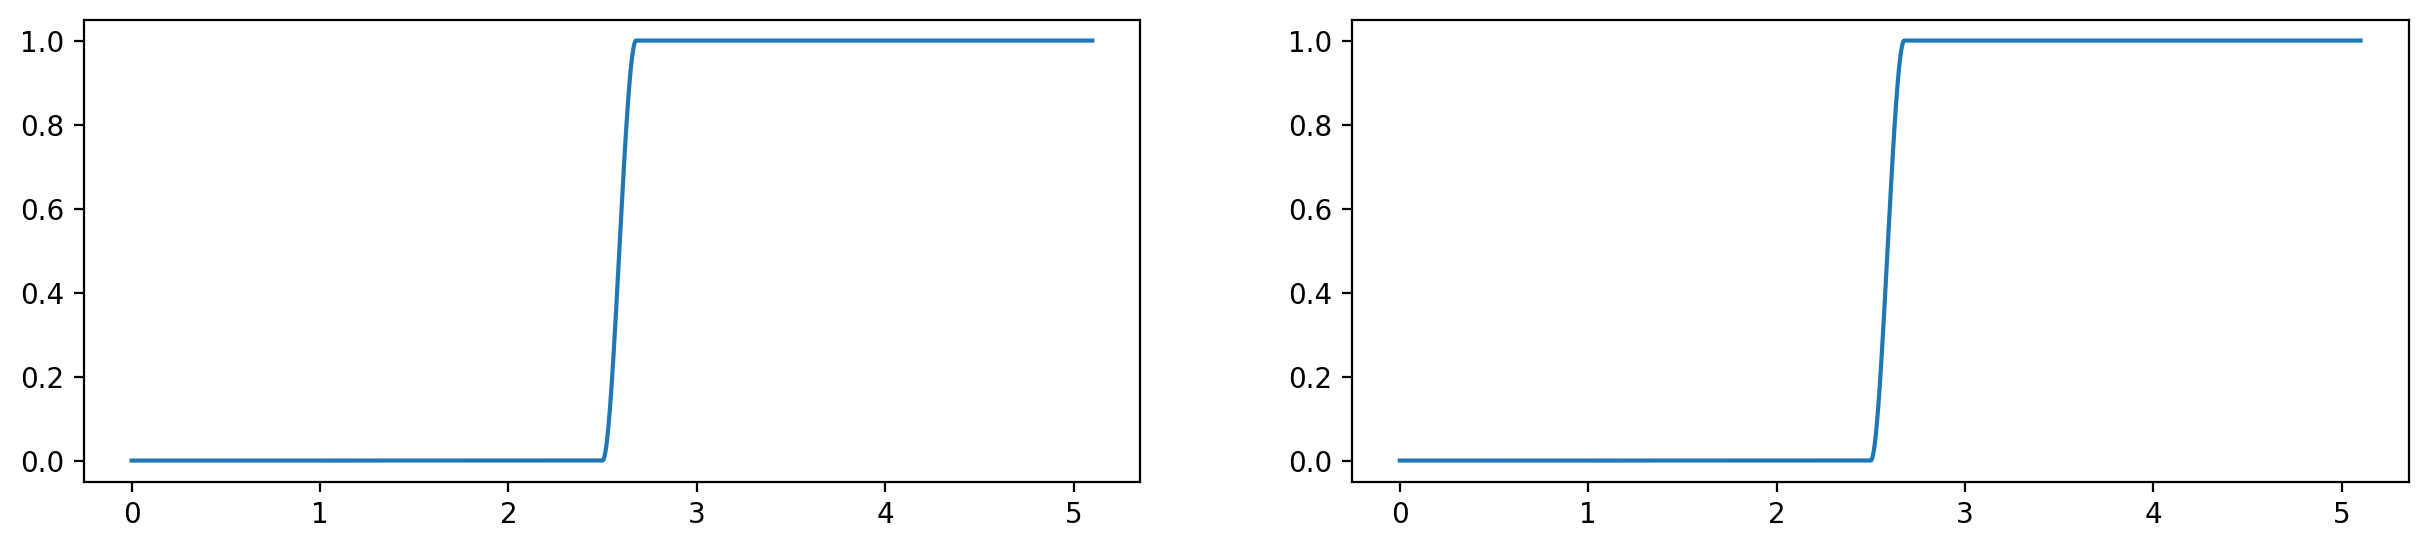

区间[2.50,5.00]的训练时间：8.60 min(s)
Final loss: 3.62360e-05,Total iteration: 15348

查看区间：[2.50,5.00]

Relative L2 error_u: 8.04419e-03

Relative L1 error_u: 5.05465e-03

Relative Linf error_u: 1.00748e-02

#小区间个数：2，总训练时长:15.21  min(s)

#查看区间[0.00,5.00]:
#error L2:6.19426e-03
#error L1:3.48331e-03
#error Linf:1.00748e-02
-----**区间个数：2, 第2次训练, 随机种子: 1420**-----
训练区间：[0.00,2.50]

	====Begin Adam====
1000,loss:5.07884e-01,i:4.95e-01,f:1.28e-02,b:1.53e-04
2000,loss:4.52540e-01,i:4.14e-01,f:3.74e-02,b:1.53e-03
3000,loss:2.56888e-01,i:1.88e-01,f:2.49e-02,b:4.37e-02
4000,loss:1.65022e-01,i:1.07e-01,f:2.42e-02,b:3.43e-02
5000,loss:9.84141e-02,i:4.71e-02,f:2.12e-02,b:3.02e-02

	====Begin LBFSG====
6000,loss:2.00107e-02,i:1.27e-03,f:3.53e-03,b:1.52e-02
7000,loss:1.04987e-02,i:2.84e-04,f:1.97e-03,b:8.25e-03
8000,loss:7.07383e-03,i:1.28e-04,f:1.17e-03,b:5.77e-03
9000,loss:4.97874e-03,i:6.95e-05,f:9.76e-04,b:3.93e-03
10000,loss:3.19956e-03,i:3.16e-05,f:6.27e-04,b:2.54e-03
11000,loss:2.11310e-03,i:2.05e-0

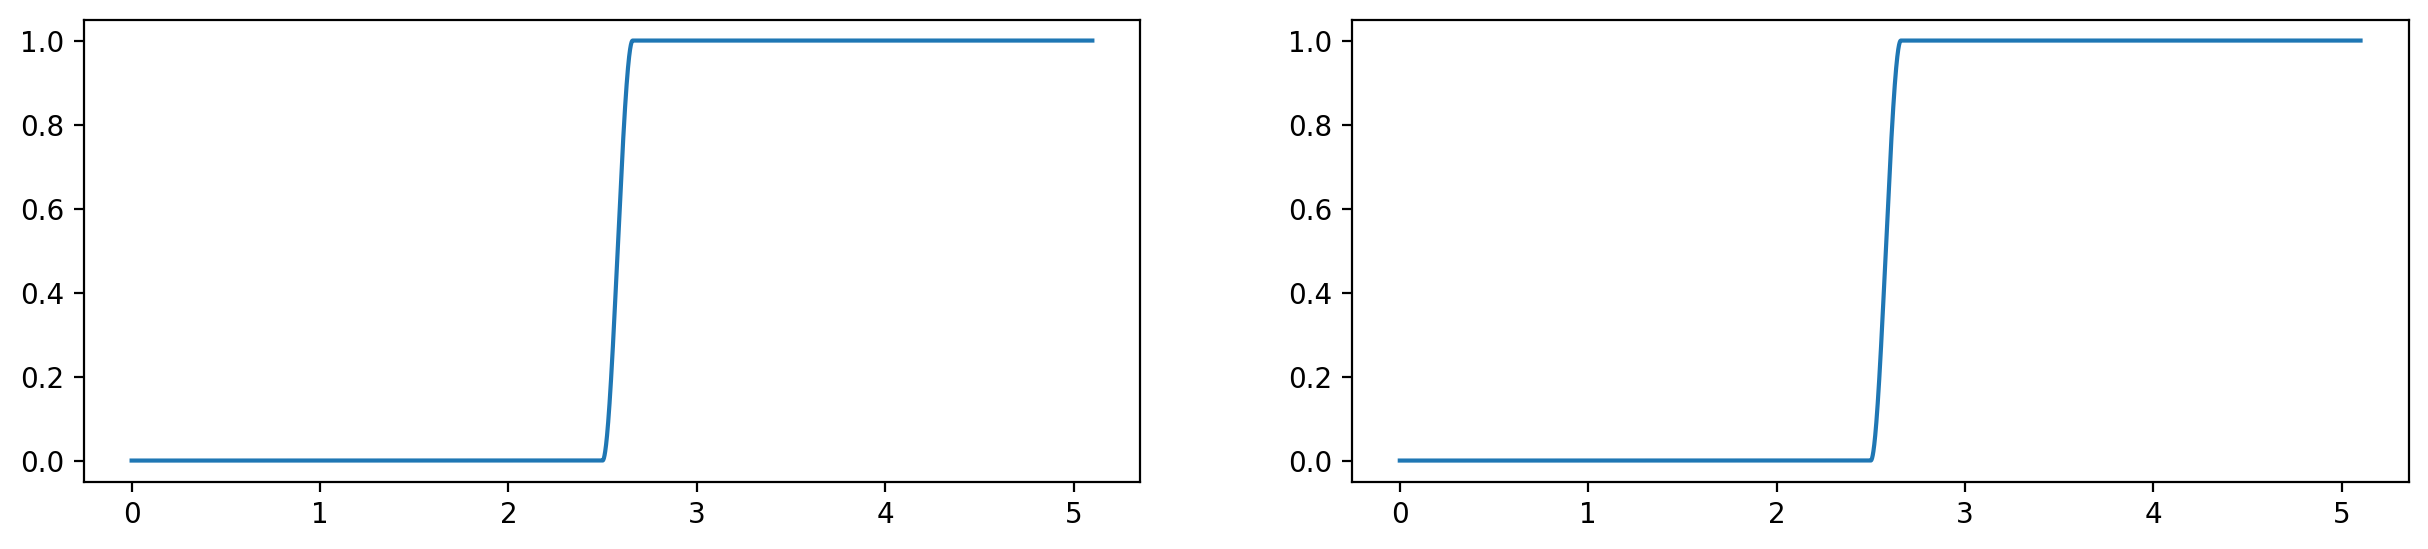

区间[2.50,5.00]的训练时间：8.72 min(s)
Final loss: 3.06643e-03,Total iteration: 15338

查看区间：[2.50,5.00]

Relative L2 error_u: 8.37283e-01

Relative L1 error_u: 5.07935e-01

Relative Linf error_u: 1.00554e+00

#小区间个数：2，总训练时长:15.37  min(s)

#查看区间[0.00,5.00]:
#error L2:5.96538e-01
#error L1:2.81903e-01
#error Linf:1.00554e+00
-----**区间个数：2, 第3次训练, 随机种子: 1156**-----
训练区间：[0.00,2.50]

	====Begin Adam====
1000,loss:5.01182e-01,i:4.95e-01,f:5.99e-03,b:2.22e-05
2000,loss:3.19540e-01,i:2.57e-01,f:5.37e-02,b:8.43e-03
3000,loss:8.06109e-02,i:3.30e-02,f:1.90e-02,b:2.86e-02
4000,loss:4.66855e-02,i:1.38e-02,f:8.73e-03,b:2.42e-02
5000,loss:4.08937e-02,i:9.48e-03,f:9.57e-03,b:2.18e-02

	====Begin LBFSG====
6000,loss:7.44615e-03,i:2.01e-04,f:1.20e-03,b:6.05e-03
7000,loss:3.43675e-03,i:3.99e-05,f:7.49e-04,b:2.65e-03
8000,loss:1.68091e-03,i:2.08e-05,f:5.77e-04,b:1.08e-03
9000,loss:6.63202e-04,i:5.02e-06,f:3.98e-04,b:2.60e-04
10000,loss:2.37946e-04,i:2.07e-06,f:2.10e-04,b:2.58e-05
11000,loss:1.26709e-04,i:2.24e-0

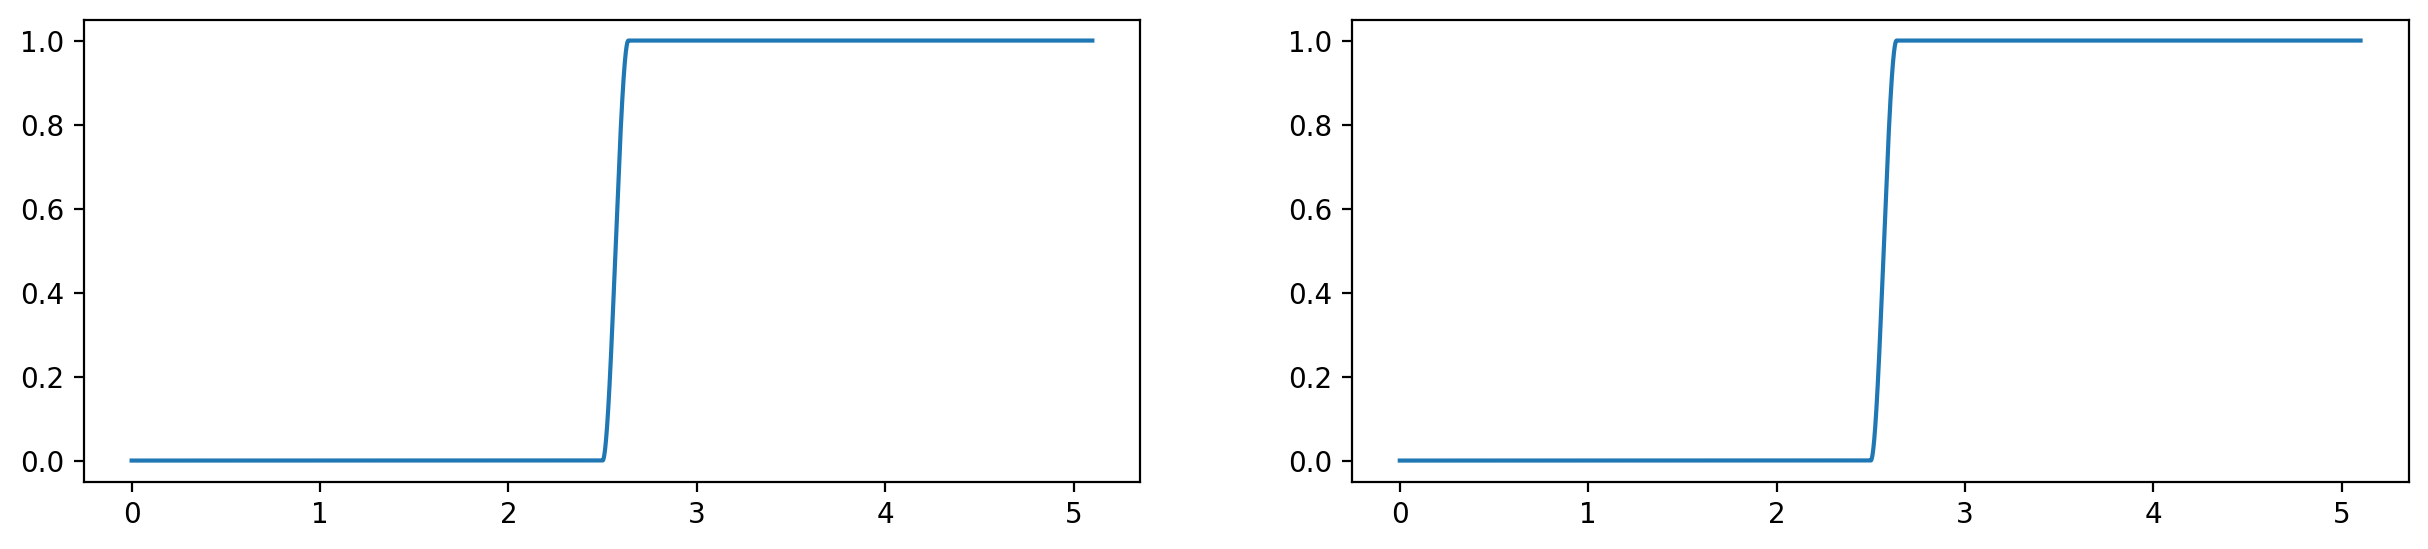

区间[2.50,5.00]的训练时间：8.51 min(s)
Final loss: 5.26633e-05,Total iteration: 15342

查看区间：[2.50,5.00]

Relative L2 error_u: 1.42955e-02

Relative L1 error_u: 8.98553e-03

Relative Linf error_u: 1.88463e-02

#小区间个数：2，总训练时长:15.22  min(s)

#查看区间[0.00,5.00]:
#error L2:1.13293e-02
#error L1:6.58472e-03
#error Linf:1.88463e-02
-----**区间个数：3, 第1次训练, 随机种子: 129**-----
训练区间：[0.00,1.67]

	====Begin Adam====
1000,loss:4.94645e-01,i:4.87e-01,f:7.86e-03,b:3.42e-05
2000,loss:4.85162e-01,i:4.76e-01,f:9.43e-03,b:1.16e-04
3000,loss:4.08845e-01,i:3.70e-01,f:3.64e-02,b:2.75e-03
4000,loss:1.79782e-01,i:1.18e-01,f:2.50e-02,b:3.70e-02
5000,loss:1.20948e-01,i:6.67e-02,f:1.70e-02,b:3.73e-02

	====Begin LBFSG====
6000,loss:1.42867e-02,i:8.95e-04,f:2.86e-03,b:1.05e-02
7000,loss:6.34283e-03,i:1.30e-04,f:1.25e-03,b:4.96e-03
8000,loss:2.75957e-03,i:3.57e-05,f:8.55e-04,b:1.87e-03
9000,loss:7.72779e-04,i:6.96e-06,f:4.38e-04,b:3.27e-04
10000,loss:2.23983e-04,i:1.37e-06,f:1.95e-04,b:2.74e-05
11000,loss:1.02468e-04,i:9.76e-07

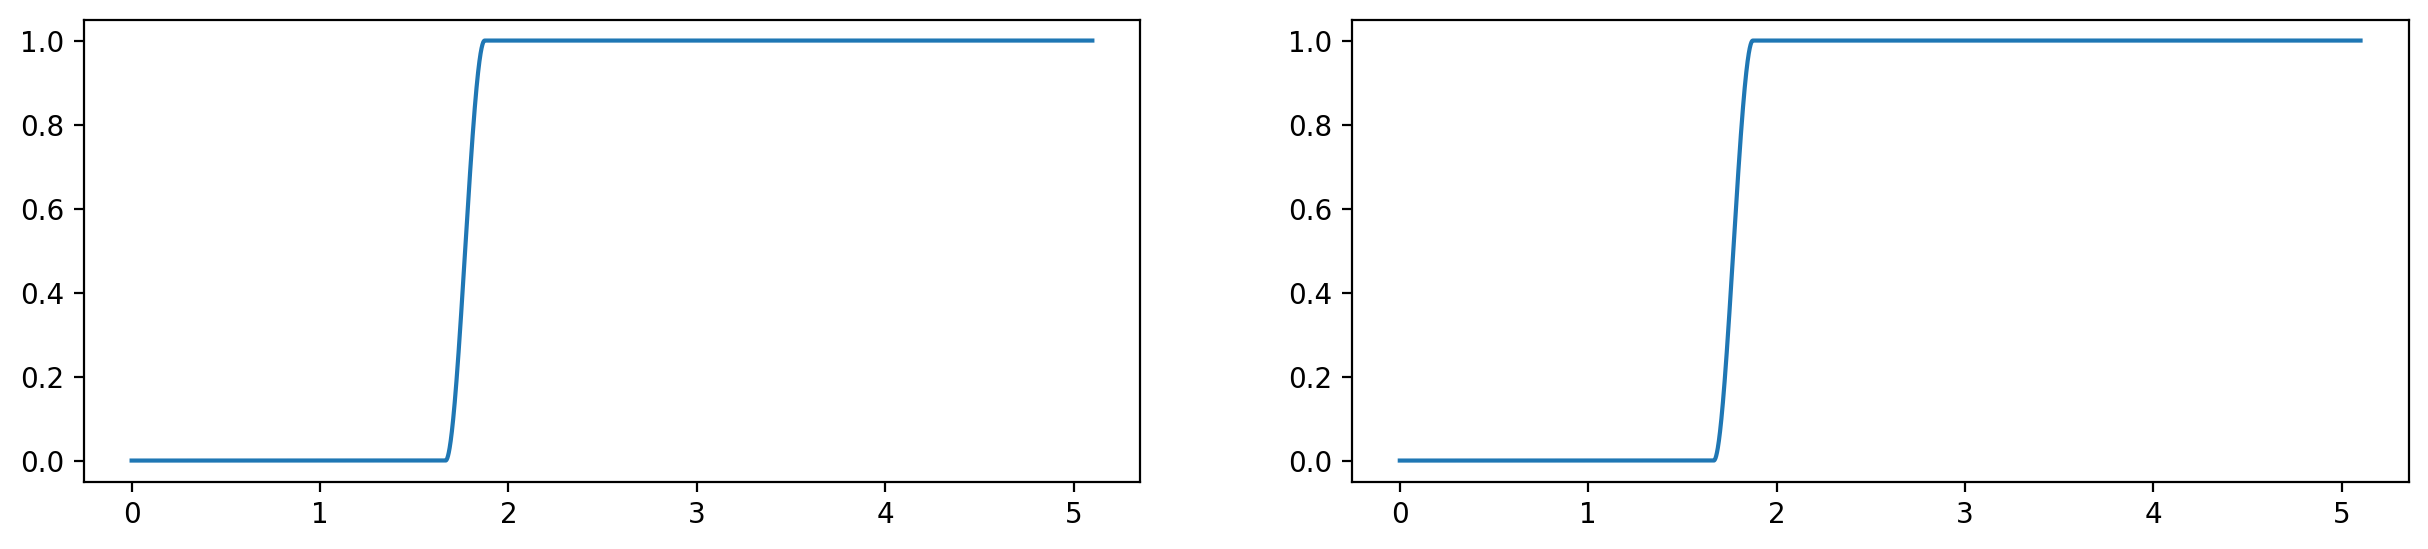

区间[1.67,3.33]的训练时间：5.87 min(s)
Final loss: 3.80602e-05,Total iteration: 11607

查看区间：[1.66,3.33]

Relative L2 error_u: 5.47522e-03

Relative L1 error_u: 3.40156e-03

Relative Linf error_u: 7.04736e-03
训练区间：[3.33,5.00]
p的初始化：4.167e+00 

	====Begin Adam====
1000,p:3.92e+00,weight0:1.00e+00,loss:2.69137e+00,i:0.00e+00,f:2.69e+00,b:1.95e-03
2000,p:3.81e+00,weight0:1.00e+00,loss:6.06653e-01,i:0.00e+00,f:6.04e-01,b:2.40e-03
3000,p:3.77e+00,weight0:1.00e+00,loss:1.92498e-01,i:0.00e+00,f:1.89e-01,b:3.34e-03
4000,p:3.76e+00,weight0:1.00e+00,loss:1.10014e-01,i:0.00e+00,f:1.06e-01,b:3.98e-03
5000,p:3.75e+00,weight0:1.00e+00,loss:7.66896e-02,i:0.00e+00,f:7.26e-02,b:4.13e-03

	====Begin LBFSG====
6000,p:3.66e+00,weight0:1.00e+00,loss:3.69006e-03,i:0.00e+00,f:2.10e-03,b:1.59e-03
7000,p:3.65e+00,weight0:1.00e+00,loss:6.74058e-04,i:0.00e+00,f:6.56e-04,b:1.83e-05
8000,p:3.64e+00,weight0:1.00e+00,loss:3.15069e-04,i:0.00e+00,f:3.14e-04,b:6.19e-07
9000,p:3.64e+00,weight0:1.00e+00,loss:1.93163e-04,i:0.00e+0

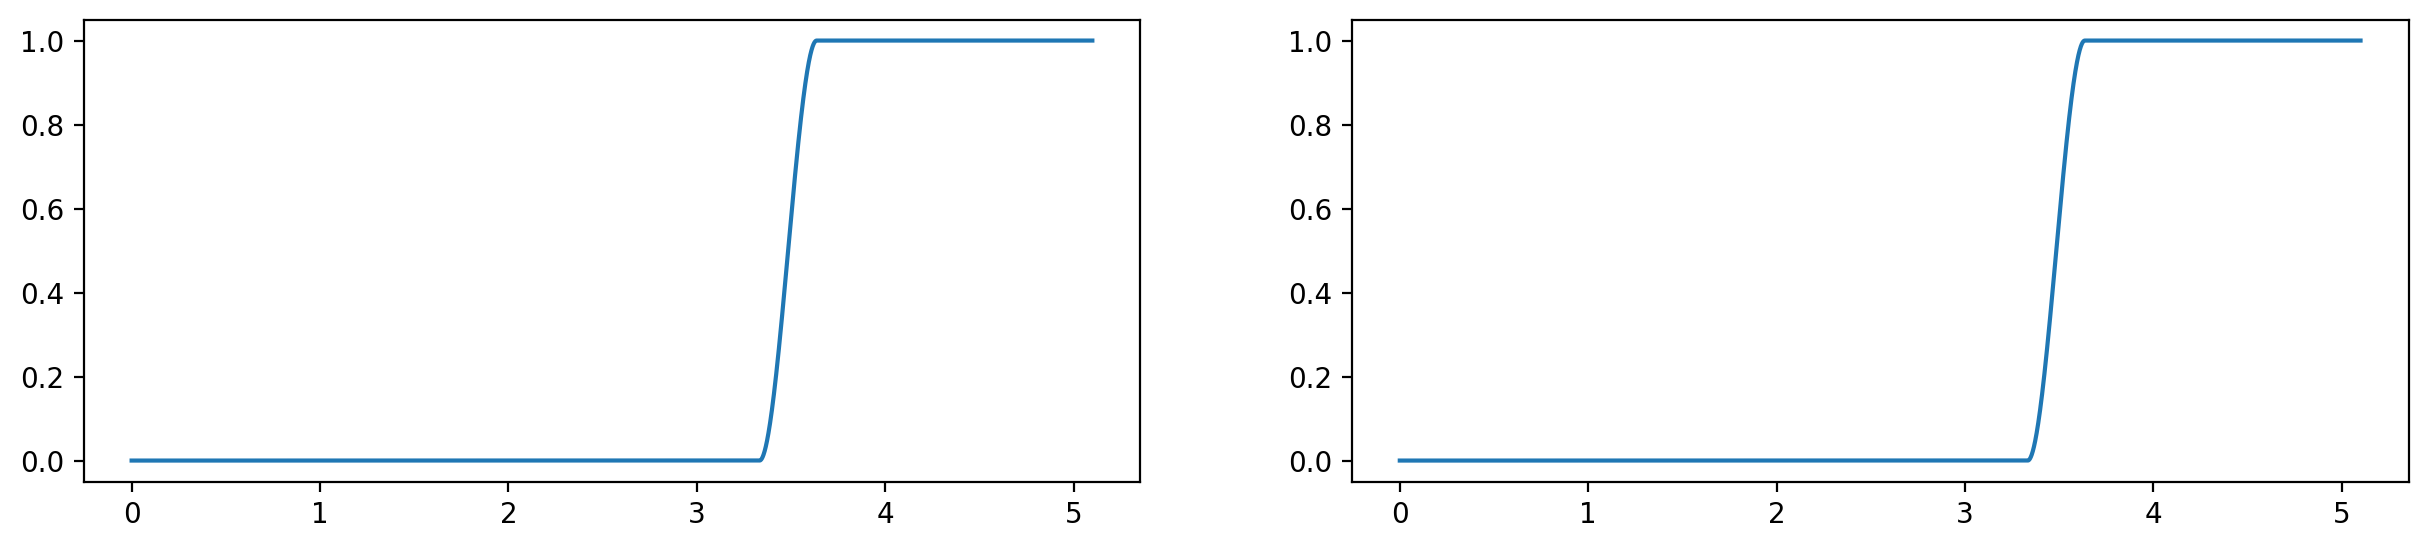

区间[3.33,5.00]的训练时间：8.67 min(s)
Final loss: 3.64514e-05,Total iteration: 15466

查看区间：[3.33,5.00]

Relative L2 error_u: 4.54139e-03

Relative L1 error_u: 2.69536e-03

Relative Linf error_u: 6.94114e-03

#小区间个数：3，总训练时长:20.36  min(s)

#查看区间[0.00,5.00]:
#error L2:4.49270e-03
#error L1:2.61918e-03
#error Linf:7.04736e-03
-----**区间个数：3, 第2次训练, 随机种子: 2401**-----
训练区间：[0.00,1.67]

	====Begin Adam====
1000,loss:2.79766e-01,i:2.11e-01,f:5.22e-02,b:1.62e-02
2000,loss:7.93062e-02,i:3.48e-02,f:1.16e-02,b:3.29e-02
3000,loss:4.23432e-02,i:1.09e-02,f:9.65e-03,b:2.18e-02
4000,loss:2.72157e-02,i:5.25e-03,f:5.08e-03,b:1.69e-02
5000,loss:2.07923e-02,i:3.09e-03,f:3.73e-03,b:1.40e-02

	====Begin LBFSG====
6000,loss:1.57078e-03,i:2.89e-05,f:7.02e-04,b:8.39e-04
7000,loss:2.54372e-04,i:9.11e-07,f:2.27e-04,b:2.62e-05
8000,loss:8.31910e-05,i:5.06e-08,f:8.29e-05,b:2.23e-07
9000,loss:4.16343e-05,i:1.80e-08,f:4.15e-05,b:1.34e-07
10000,loss:2.53807e-05,i:1.05e-08,f:2.52e-05,b:1.60e-07
11000,loss:1.67739e-05,i:9.67e-0

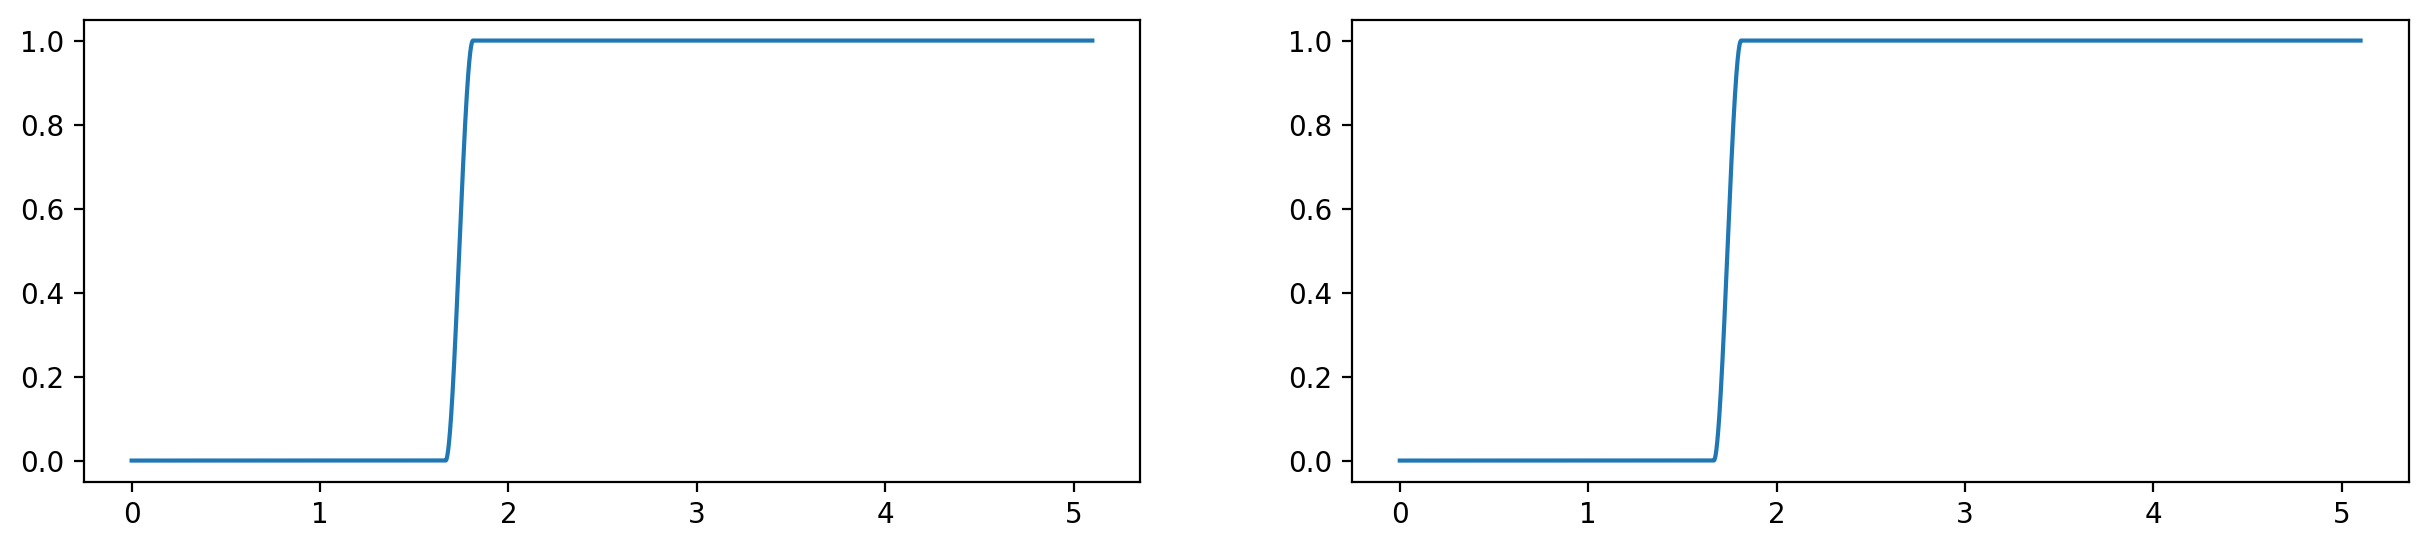

区间[1.67,3.33]的训练时间：6.50 min(s)
Final loss: 6.05605e-05,Total iteration: 12412

查看区间：[1.66,3.33]

Relative L2 error_u: 1.12207e-02

Relative L1 error_u: 6.74712e-03

Relative Linf error_u: 1.84882e-02
训练区间：[3.33,5.00]
p的初始化：4.167e+00 

	====Begin Adam====
1000,p:3.90e+00,weight0:1.00e+00,loss:1.76432e+01,i:0.00e+00,f:1.76e+01,b:9.46e-04
2000,p:3.49e+00,weight0:1.00e+00,loss:5.22104e-01,i:0.00e+00,f:5.06e-01,b:1.66e-02
3000,p:3.48e+00,weight0:1.00e+00,loss:2.30203e-01,i:0.00e+00,f:2.16e-01,b:1.42e-02
4000,p:3.48e+00,weight0:1.00e+00,loss:1.14883e-01,i:0.00e+00,f:1.01e-01,b:1.36e-02
5000,p:3.47e+00,weight0:1.00e+00,loss:6.77919e-02,i:0.00e+00,f:5.55e-02,b:1.23e-02

	====Begin LBFSG====
6000,p:3.45e+00,weight0:1.00e+00,loss:5.96683e-03,i:0.00e+00,f:2.20e-03,b:3.77e-03
7000,p:3.45e+00,weight0:1.00e+00,loss:1.53461e-03,i:0.00e+00,f:1.06e-03,b:4.74e-04
8000,p:3.45e+00,weight0:1.00e+00,loss:4.72900e-04,i:0.00e+00,f:4.52e-04,b:2.06e-05
9000,p:3.45e+00,weight0:1.00e+00,loss:2.75041e-04,i:0.00e+0

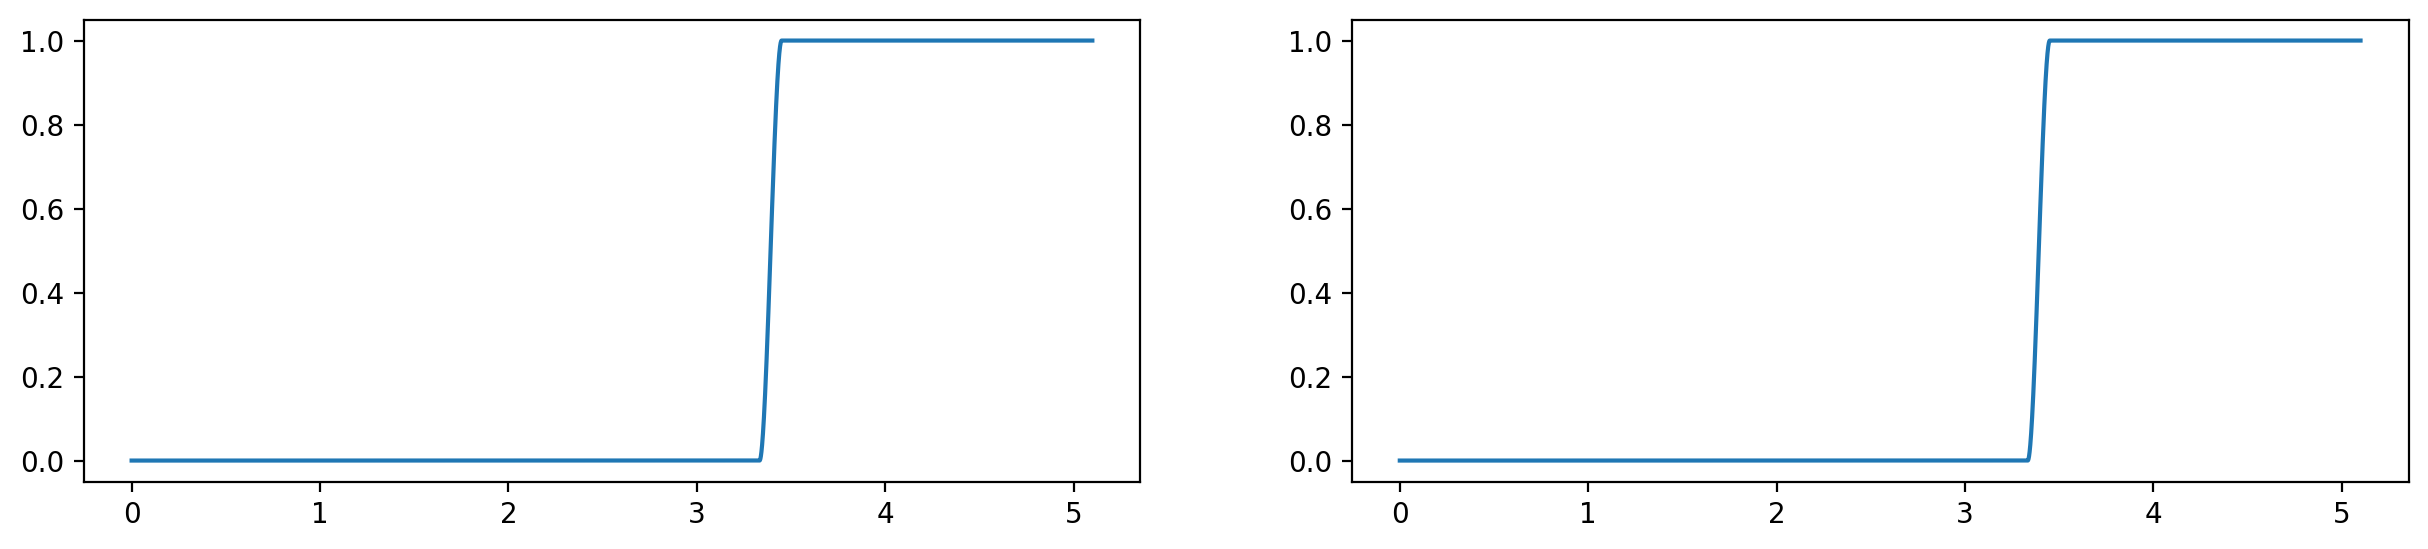

区间[3.33,5.00]的训练时间：6.84 min(s)
Final loss: 1.11374e-04,Total iteration: 12717

查看区间：[3.33,5.00]

Relative L2 error_u: 1.66865e-02

Relative L1 error_u: 1.05940e-02

Relative Linf error_u: 1.89801e-02

#小区间个数：3，总训练时长:18.34  min(s)

#查看区间[0.00,5.00]:
#error L2:1.17020e-02
#error L1:6.22609e-03
#error Linf:1.89801e-02
-----**区间个数：3, 第3次训练, 随机种子: 477**-----
训练区间：[0.00,1.67]

	====Begin Adam====
1000,loss:4.63796e-01,i:4.42e-01,f:2.17e-02,b:1.46e-04
2000,loss:2.02474e-01,i:1.35e-01,f:2.92e-02,b:3.80e-02
3000,loss:1.00306e-01,i:4.78e-02,f:1.43e-02,b:3.81e-02
4000,loss:6.22759e-02,i:2.20e-02,f:1.06e-02,b:2.97e-02
5000,loss:4.24354e-02,i:1.14e-02,f:7.35e-03,b:2.37e-02

	====Begin LBFSG====
6000,loss:3.22024e-03,i:6.00e-05,f:1.07e-03,b:2.09e-03
7000,loss:3.92693e-04,i:2.02e-06,f:3.15e-04,b:7.54e-05
8000,loss:9.50250e-05,i:5.40e-07,f:9.32e-05,b:1.29e-06
9000,loss:4.43989e-05,i:1.39e-07,f:4.36e-05,b:6.22e-07
10000,loss:2.52008e-05,i:4.80e-08,f:2.49e-05,b:2.62e-07
11000,loss:1.57215e-05,i:1.15e-08

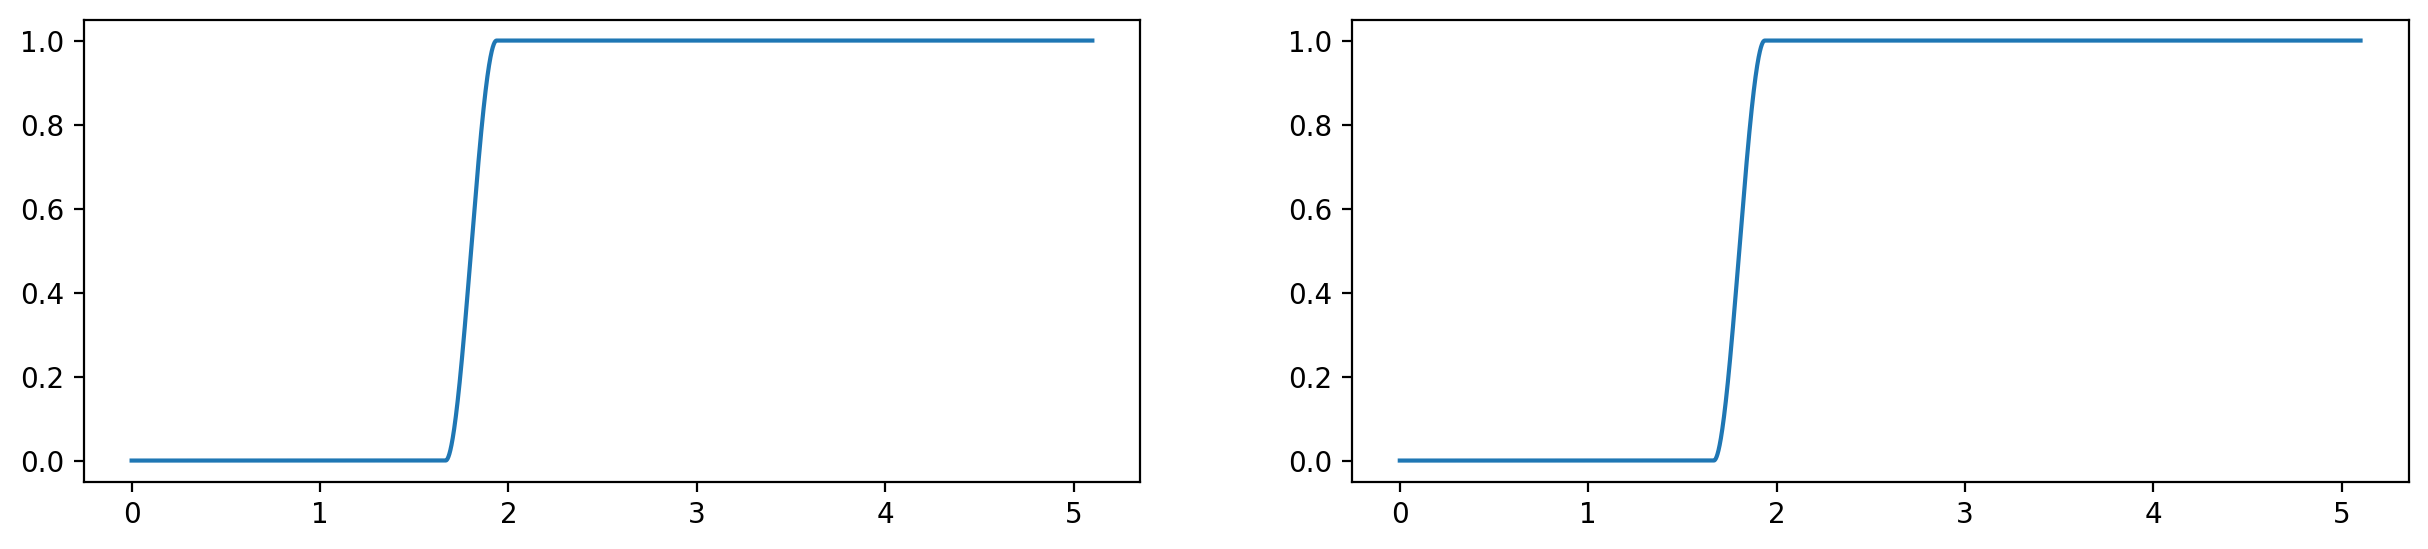

区间[1.67,3.33]的训练时间：8.72 min(s)
Final loss: 2.11140e-05,Total iteration: 15366

查看区间：[1.66,3.33]

Relative L2 error_u: 6.65365e-03

Relative L1 error_u: 4.16091e-03

Relative Linf error_u: 8.74513e-03
训练区间：[3.33,5.00]
p的初始化：4.167e+00 

	====Begin Adam====
1000,p:3.90e+00,weight0:1.00e+00,loss:6.72106e+00,i:0.00e+00,f:6.72e+00,b:4.07e-03
2000,p:3.79e+00,weight0:1.00e+00,loss:3.03926e+00,i:0.00e+00,f:3.04e+00,b:1.42e-03
3000,p:3.69e+00,weight0:1.00e+00,loss:1.29098e+00,i:0.00e+00,f:1.29e+00,b:1.66e-03
4000,p:3.63e+00,weight0:1.00e+00,loss:5.18320e-01,i:0.00e+00,f:5.04e-01,b:1.45e-02
5000,p:3.60e+00,weight0:1.00e+00,loss:4.30395e-01,i:0.00e+00,f:4.11e-01,b:1.91e-02

	====Begin LBFSG====
6000,p:3.54e+00,weight0:1.00e+00,loss:1.52552e-02,i:0.00e+00,f:3.53e-03,b:1.17e-02
7000,p:3.54e+00,weight0:1.00e+00,loss:7.77842e-03,i:0.00e+00,f:1.70e-03,b:6.08e-03
8000,p:3.54e+00,weight0:1.00e+00,loss:2.75515e-03,i:0.00e+00,f:1.26e-03,b:1.50e-03
9000,p:3.54e+00,weight0:1.00e+00,loss:6.14690e-04,i:0.00e+0

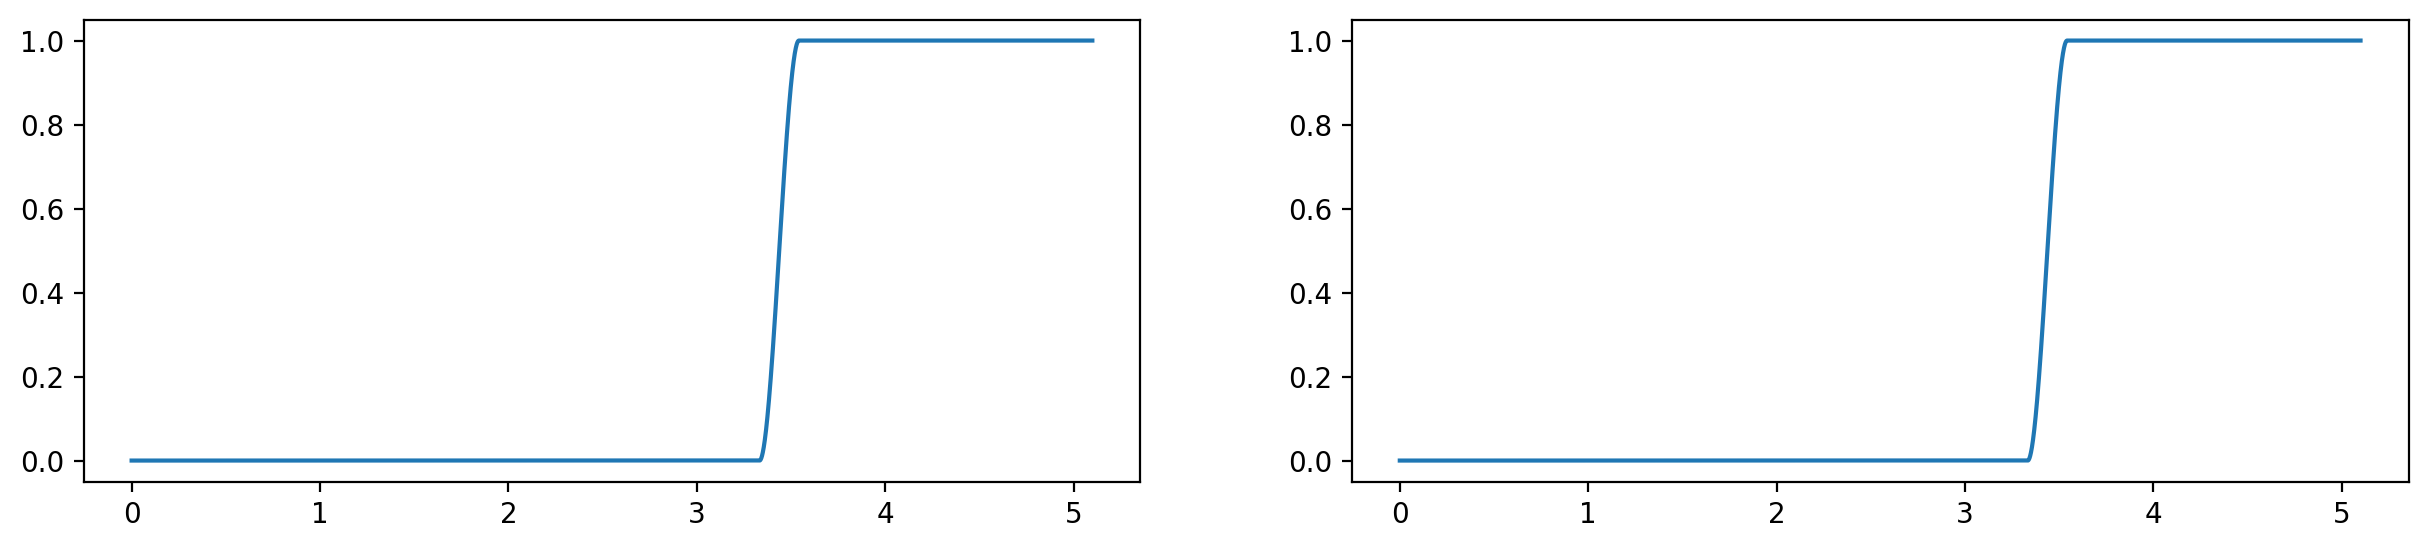

区间[3.33,5.00]的训练时间：8.38 min(s)
Final loss: 6.41557e-05,Total iteration: 14506

查看区间：[3.33,5.00]

Relative L2 error_u: 7.27633e-03

Relative L1 error_u: 4.59778e-03

Relative Linf error_u: 8.86333e-03

#小区间个数：3，总训练时长:22.55  min(s)

#查看区间[0.00,5.00]:
#error L2:5.79017e-03
#error L1:3.24166e-03
#error Linf:8.86333e-03
-----**区间个数：4, 第1次训练, 随机种子: 783**-----
训练区间：[0.00,1.25]

	====Begin Adam====
1000,loss:4.91487e-01,i:4.82e-01,f:9.26e-03,b:2.71e-05
2000,loss:4.02235e-01,i:3.64e-01,f:3.66e-02,b:1.43e-03
3000,loss:6.89348e-02,i:2.58e-02,f:1.09e-02,b:3.22e-02
4000,loss:5.97448e-02,i:6.98e-03,f:3.20e-02,b:2.07e-02
5000,loss:2.29672e-02,i:3.29e-03,f:3.91e-03,b:1.58e-02

	====Begin LBFSG====
6000,loss:4.32027e-04,i:9.89e-07,f:3.78e-04,b:5.35e-05
7000,loss:7.90677e-05,i:1.46e-07,f:7.80e-05,b:9.55e-07
8000,loss:2.95504e-05,i:5.23e-08,f:2.92e-05,b:2.71e-07
9000,loss:1.47218e-05,i:2.53e-09,f:1.46e-05,b:9.67e-08
10000,loss:8.81917e-06,i:5.31e-09,f:8.78e-06,b:3.72e-08
区间[0.00,1.25]的训练时间：3.83 min(s)
Fi

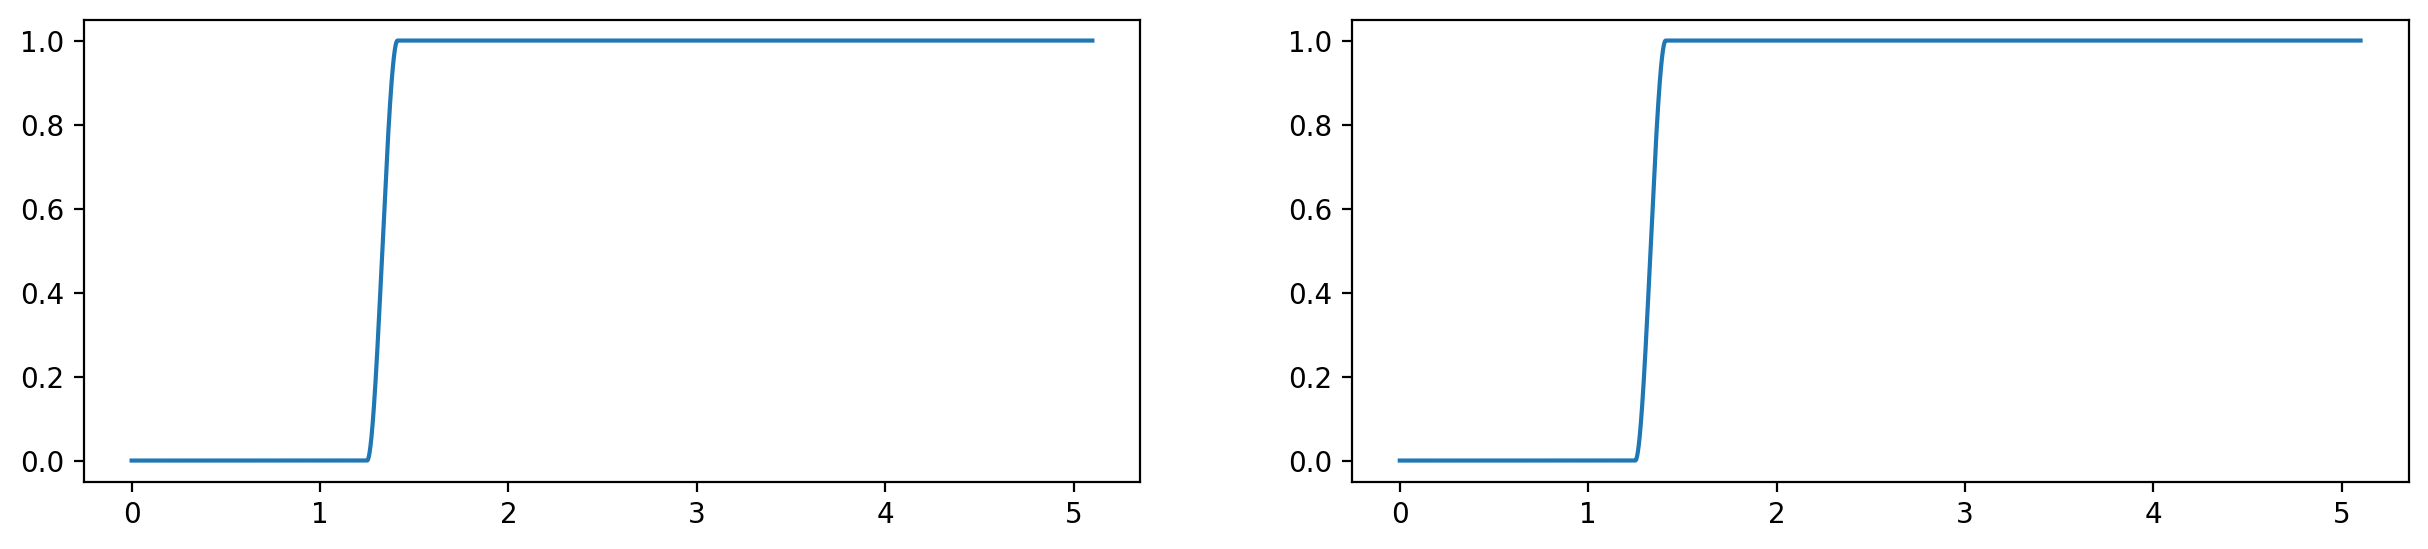

区间[1.25,2.50]的训练时间：8.97 min(s)
Final loss: 3.00243e-05,Total iteration: 15188

查看区间：[1.25,2.50]

Relative L2 error_u: 2.87369e-03

Relative L1 error_u: 1.73221e-03

Relative Linf error_u: 4.92606e-03
训练区间：[2.50,3.75]
p的初始化：3.125e+00 

	====Begin Adam====
1000,p:2.65e+00,weight0:1.00e+00,loss:5.92676e-01,i:0.00e+00,f:5.66e-01,b:2.64e-02
2000,p:2.64e+00,weight0:1.00e+00,loss:1.31829e-01,i:0.00e+00,f:1.09e-01,b:2.29e-02
3000,p:2.63e+00,weight0:1.00e+00,loss:8.87966e-02,i:0.00e+00,f:6.62e-02,b:2.26e-02
4000,p:2.63e+00,weight0:1.00e+00,loss:6.72043e-02,i:0.00e+00,f:4.53e-02,b:2.19e-02
5000,p:2.63e+00,weight0:1.00e+00,loss:4.84352e-02,i:0.00e+00,f:2.73e-02,b:2.11e-02

	====Begin LBFSG====
6000,p:2.63e+00,weight0:1.00e+00,loss:1.42611e-02,i:0.00e+00,f:2.27e-03,b:1.20e-02
7000,p:2.63e+00,weight0:1.00e+00,loss:8.66623e-03,i:0.00e+00,f:1.96e-03,b:6.70e-03
8000,p:2.63e+00,weight0:1.00e+00,loss:2.38737e-03,i:0.00e+00,f:1.65e-03,b:7.36e-04
9000,p:2.63e+00,weight0:1.00e+00,loss:7.40618e-04,i:0.00e+0

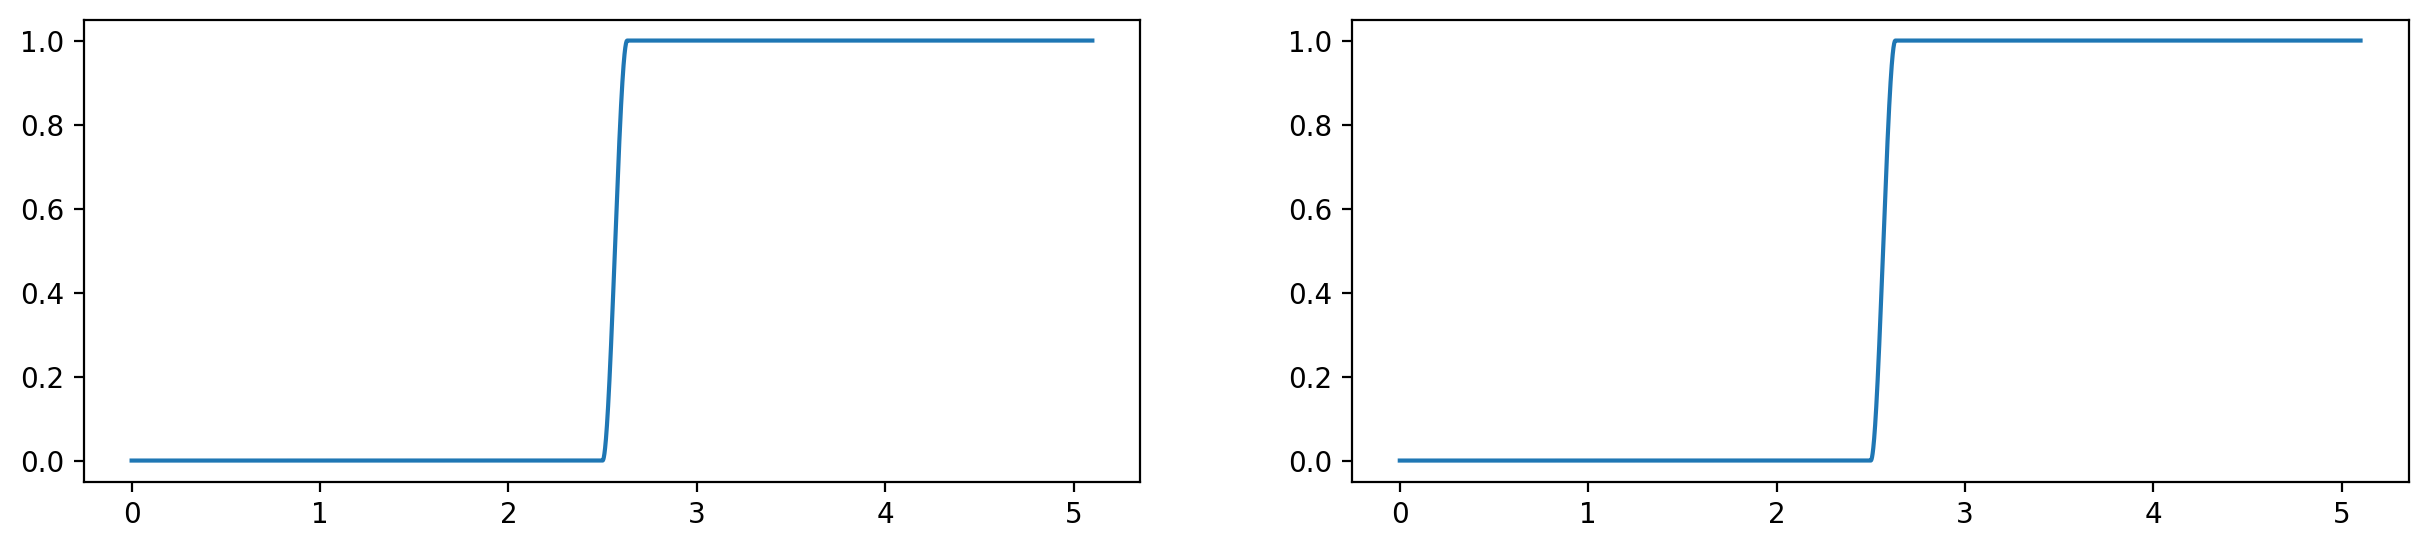

区间[2.50,3.75]的训练时间：8.79 min(s)
Final loss: 1.53340e-04,Total iteration: 14223

查看区间：[2.50,3.75]

Relative L2 error_u: 4.47681e-03

Relative L1 error_u: 2.60595e-03

Relative Linf error_u: 8.61931e-03
训练区间：[3.75,5.00]
p的初始化：4.375e+00 

	====Begin Adam====
1000,p:3.98e+00,weight0:1.00e+00,loss:1.53831e+00,i:0.00e+00,f:1.53e+00,b:8.29e-03
2000,p:3.95e+00,weight0:1.00e+00,loss:5.32233e-01,i:0.00e+00,f:5.23e-01,b:9.09e-03
3000,p:3.94e+00,weight0:1.00e+00,loss:2.43757e-01,i:0.00e+00,f:2.31e-01,b:1.32e-02
4000,p:3.93e+00,weight0:1.00e+00,loss:1.33599e-01,i:0.00e+00,f:1.17e-01,b:1.69e-02
5000,p:3.92e+00,weight0:1.00e+00,loss:9.87941e-02,i:0.00e+00,f:7.99e-02,b:1.88e-02

	====Begin LBFSG====
6000,p:3.91e+00,weight0:1.00e+00,loss:1.32628e-02,i:0.00e+00,f:3.12e-03,b:1.01e-02
7000,p:3.91e+00,weight0:1.00e+00,loss:2.81325e-03,i:0.00e+00,f:1.74e-03,b:1.07e-03
8000,p:3.91e+00,weight0:1.00e+00,loss:5.82211e-04,i:0.00e+00,f:5.45e-04,b:3.71e-05
9000,p:3.91e+00,weight0:1.00e+00,loss:2.77186e-04,i:0.00e+0

区间[3.75,5.00]的训练时间：7.25 min(s)
Final loss: 1.07202e-04,Total iteration: 12072

查看区间：[3.75,5.00]

Relative L2 error_u: 1.34256e-02

Relative L1 error_u: 7.83056e-03

Relative Linf error_u: 1.91917e-02

#小区间个数：4，总训练时长:28.83  min(s)

#查看区间[0.00,5.00]:
#error L2:7.23741e-03
#error L1:3.15397e-03
#error Linf:1.91917e-02
-----**区间个数：4, 第2次训练, 随机种子: 529**-----
训练区间：[0.00,1.25]

	====Begin Adam====
1000,loss:4.82976e-01,i:4.77e-01,f:5.95e-03,b:1.65e-05
2000,loss:4.67534e-01,i:4.56e-01,f:1.17e-02,b:9.76e-05
3000,loss:1.06491e-01,i:5.32e-02,f:1.79e-02,b:3.53e-02
4000,loss:4.99566e-02,i:1.47e-02,f:8.39e-03,b:2.68e-02
5000,loss:3.06383e-02,i:5.83e-03,f:5.34e-03,b:1.95e-02

	====Begin LBFSG====
6000,loss:8.54720e-04,i:6.54e-06,f:6.32e-04,b:2.17e-04
7000,loss:1.16495e-04,i:9.91e-08,f:1.16e-04,b:5.47e-07
8000,loss:4.07667e-05,i:7.28e-08,f:4.01e-05,b:6.11e-07
9000,loss:2.03374e-05,i:2.90e-08,f:2.00e-05,b:2.75e-07
10000,loss:1.24360e-05,i:5.38e-09,f:1.24e-05,b:7.95e-08
11000,loss:8.18742e-06,i:2.45e-09

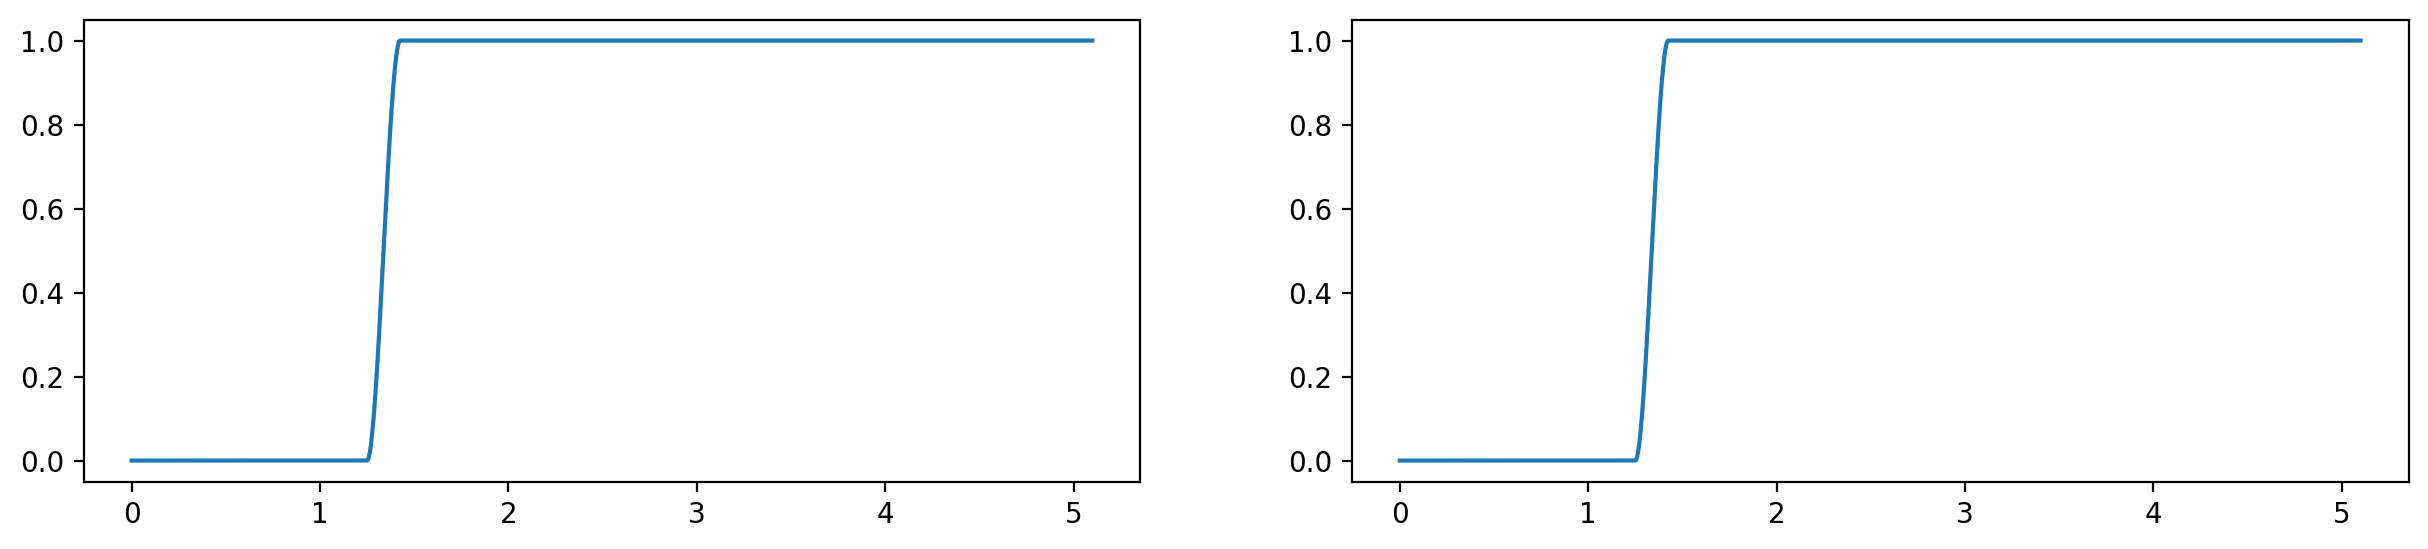

区间[1.25,2.50]的训练时间：6.84 min(s)
Final loss: 2.67704e-05,Total iteration: 11991

查看区间：[1.25,2.50]

Relative L2 error_u: 2.27348e-03

Relative L1 error_u: 1.37976e-03

Relative Linf error_u: 3.48216e-03
训练区间：[2.50,3.75]
p的初始化：3.125e+00 

	====Begin Adam====
1000,p:2.69e+00,weight0:1.00e+00,loss:2.21602e-01,i:0.00e+00,f:2.12e-01,b:1.00e-02
2000,p:2.68e+00,weight0:1.00e+00,loss:5.67879e-02,i:0.00e+00,f:4.38e-02,b:1.30e-02
3000,p:2.68e+00,weight0:1.00e+00,loss:1.30230e-01,i:0.00e+00,f:1.18e-01,b:1.22e-02
4000,p:2.67e+00,weight0:1.00e+00,loss:3.34672e-02,i:0.00e+00,f:2.20e-02,b:1.15e-02
5000,p:2.67e+00,weight0:1.00e+00,loss:1.03507e-01,i:0.00e+00,f:9.27e-02,b:1.08e-02

	====Begin LBFSG====
6000,p:2.64e+00,weight0:1.00e+00,loss:8.47187e-04,i:0.00e+00,f:7.69e-04,b:7.78e-05
7000,p:2.64e+00,weight0:1.00e+00,loss:1.77834e-04,i:0.00e+00,f:1.72e-04,b:5.88e-06
8000,p:2.64e+00,weight0:1.00e+00,loss:8.43952e-05,i:0.00e+00,f:8.10e-05,b:3.40e-06
9000,p:2.64e+00,weight0:1.00e+00,loss:5.58307e-05,i:0.00e+0

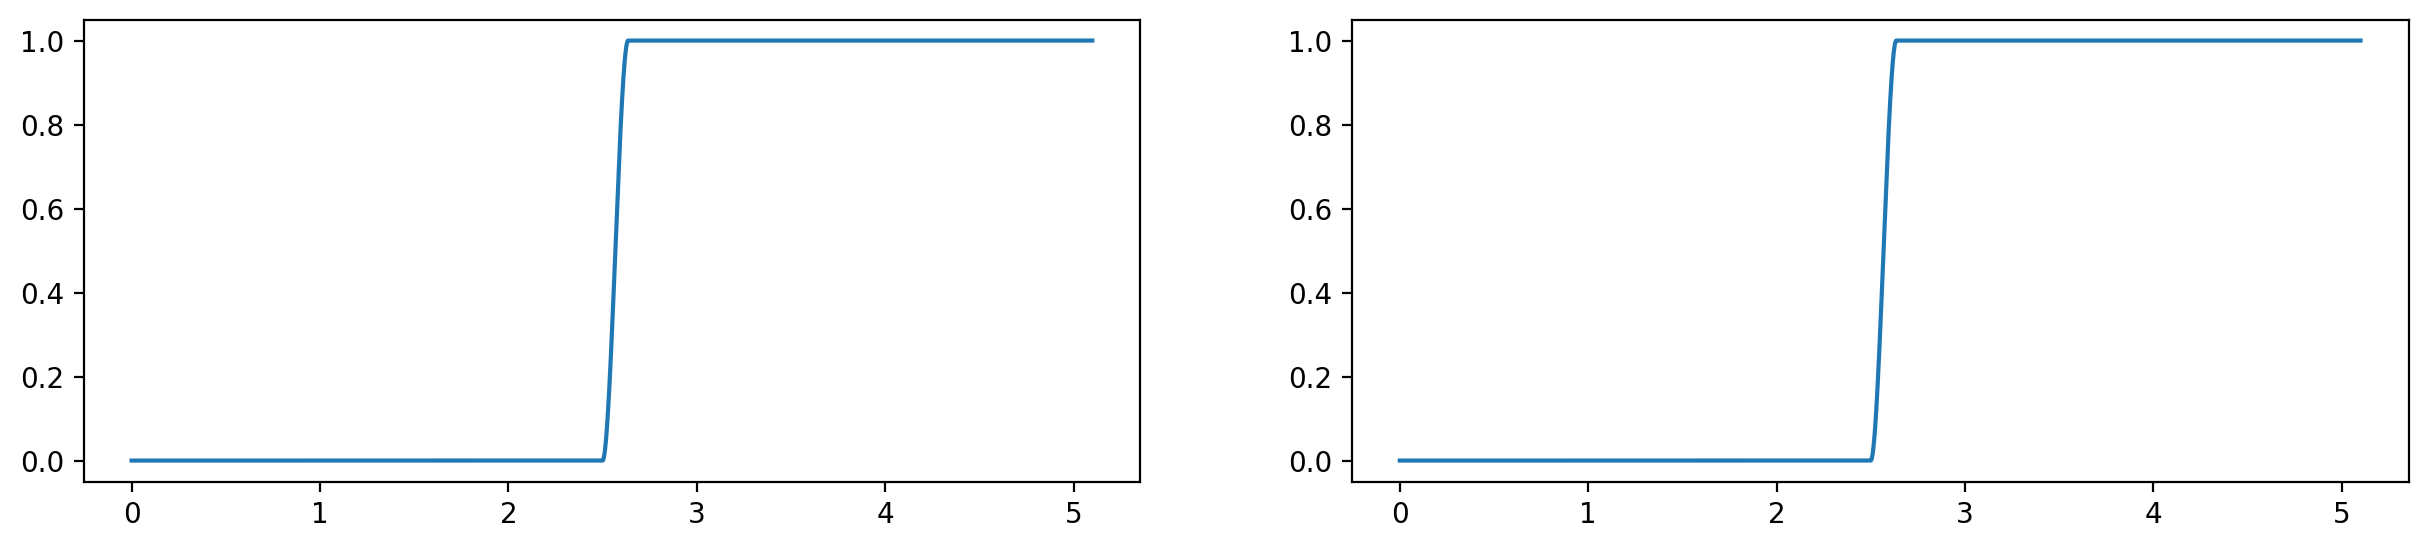

区间[2.50,3.75]的训练时间：6.37 min(s)
Final loss: 2.74014e-05,Total iteration: 11518

查看区间：[2.50,3.75]

Relative L2 error_u: 6.50919e-03

Relative L1 error_u: 4.03876e-03

Relative Linf error_u: 1.07422e-02
训练区间：[3.75,5.00]
p的初始化：4.375e+00 

	====Begin Adam====
1000,p:3.92e+00,weight0:1.00e+00,loss:1.35917e+00,i:0.00e+00,f:1.34e+00,b:1.43e-02
2000,p:3.89e+00,weight0:1.00e+00,loss:1.92183e-01,i:0.00e+00,f:1.68e-01,b:2.39e-02
3000,p:3.89e+00,weight0:1.00e+00,loss:1.01195e-01,i:0.00e+00,f:7.74e-02,b:2.38e-02
4000,p:3.89e+00,weight0:1.00e+00,loss:1.05963e-01,i:0.00e+00,f:8.23e-02,b:2.36e-02
5000,p:3.89e+00,weight0:1.00e+00,loss:5.66878e-02,i:0.00e+00,f:3.51e-02,b:2.16e-02

	====Begin LBFSG====
6000,p:3.87e+00,weight0:1.00e+00,loss:3.05193e-03,i:0.00e+00,f:2.07e-03,b:9.79e-04
7000,p:3.87e+00,weight0:1.00e+00,loss:4.94215e-04,i:0.00e+00,f:4.88e-04,b:6.66e-06
8000,p:3.87e+00,weight0:1.00e+00,loss:2.25727e-04,i:0.00e+00,f:2.24e-04,b:2.20e-06
9000,p:3.87e+00,weight0:1.00e+00,loss:1.48635e-04,i:0.00e+0

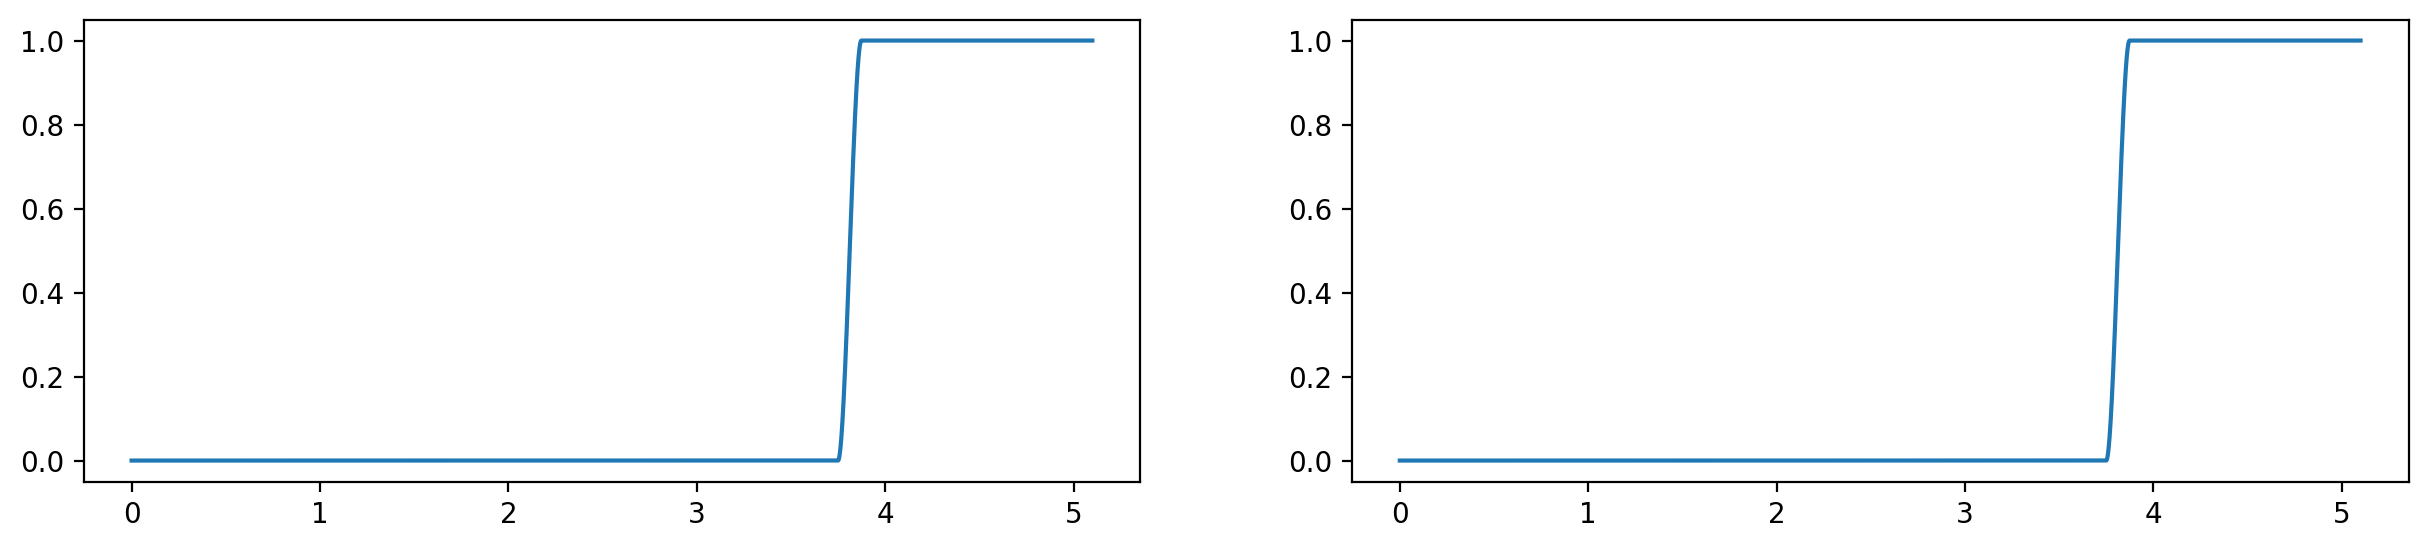

区间[3.75,5.00]的训练时间：7.50 min(s)
Final loss: 6.59027e-05,Total iteration: 12495

查看区间：[3.75,5.00]

Relative L2 error_u: 1.00286e-02

Relative L1 error_u: 5.98562e-03

Relative Linf error_u: 1.33360e-02

#小区间个数：4，总训练时长:25.28  min(s)

#查看区间[0.00,5.00]:
#error L2:6.10937e-03
#error L1:2.97782e-03
#error Linf:1.33360e-02
-----**区间个数：4, 第3次训练, 随机种子: 1592**-----
训练区间：[0.00,1.25]

	====Begin Adam====
1000,loss:4.92791e-01,i:4.87e-01,f:5.91e-03,b:1.71e-05
2000,loss:4.85076e-01,i:4.79e-01,f:6.17e-03,b:2.02e-05
3000,loss:3.07134e-01,i:2.50e-01,f:4.38e-02,b:1.31e-02
4000,loss:1.49517e-01,i:7.75e-02,f:2.17e-02,b:5.02e-02
5000,loss:1.91337e-01,i:3.60e-02,f:1.08e-01,b:4.69e-02

	====Begin LBFSG====
6000,loss:2.43538e-02,i:1.35e-03,f:3.31e-03,b:1.97e-02
7000,loss:1.36648e-02,i:6.60e-04,f:2.02e-03,b:1.10e-02
8000,loss:3.82348e-03,i:4.42e-05,f:1.81e-03,b:1.97e-03
9000,loss:6.58524e-04,i:4.78e-06,f:5.79e-04,b:7.43e-05
10000,loss:2.26915e-04,i:3.53e-07,f:2.22e-04,b:4.91e-06
11000,loss:1.18484e-04,i:2.65e-0

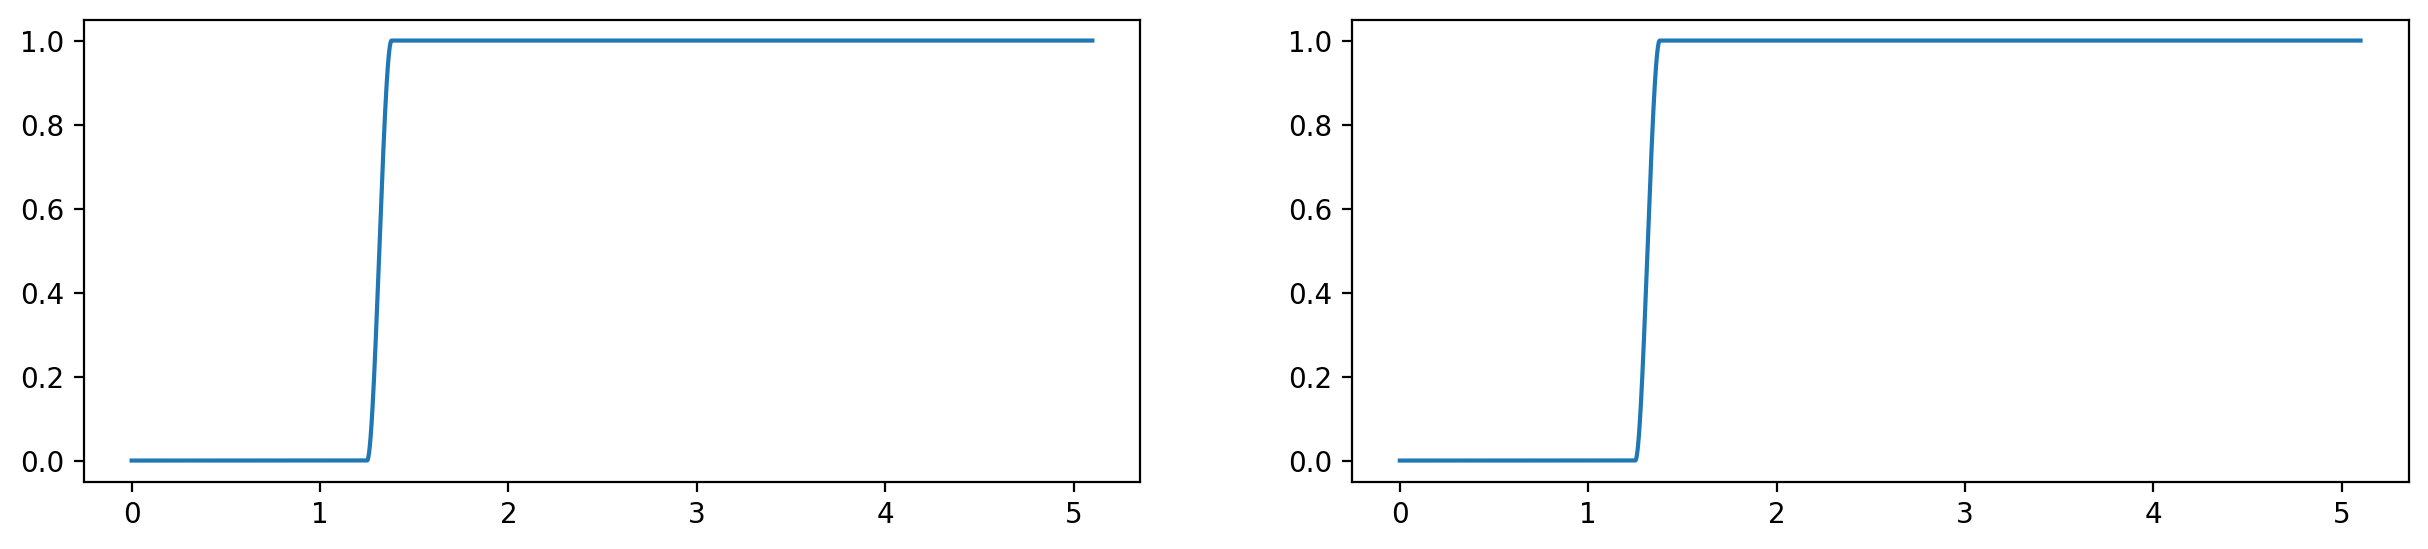

区间[1.25,2.50]的训练时间：10.67 min(s)
Final loss: 7.30409e-05,Total iteration: 13852

查看区间：[1.25,2.50]

Relative L2 error_u: 1.03330e-02

Relative L1 error_u: 6.44323e-03

Relative Linf error_u: 1.35414e-02
训练区间：[2.50,3.75]
p的初始化：3.125e+00 

	====Begin Adam====
1000,p:3.00e+00,weight0:1.00e+00,loss:6.23624e+00,i:0.00e+00,f:6.24e+00,b:9.88e-04
2000,p:2.89e+00,weight0:1.00e+00,loss:8.95144e-01,i:0.00e+00,f:8.91e-01,b:3.74e-03
3000,p:2.85e+00,weight0:1.00e+00,loss:3.00546e-01,i:0.00e+00,f:2.94e-01,b:6.56e-03
4000,p:2.84e+00,weight0:1.00e+00,loss:1.47958e-01,i:0.00e+00,f:1.41e-01,b:6.77e-03
5000,p:2.84e+00,weight0:1.00e+00,loss:1.11303e-01,i:0.00e+00,f:1.05e-01,b:6.43e-03

	====Begin LBFSG====
6000,p:2.79e+00,weight0:1.00e+00,loss:2.66051e-03,i:0.00e+00,f:2.54e-03,b:1.22e-04
7000,p:2.79e+00,weight0:1.00e+00,loss:7.22143e-04,i:0.00e+00,f:6.92e-04,b:2.99e-05
8000,p:2.80e+00,weight0:1.00e+00,loss:3.75380e-04,i:0.00e+00,f:3.63e-04,b:1.23e-05
9000,p:2.80e+00,weight0:1.00e+00,loss:2.60226e-04,i:0.00e+

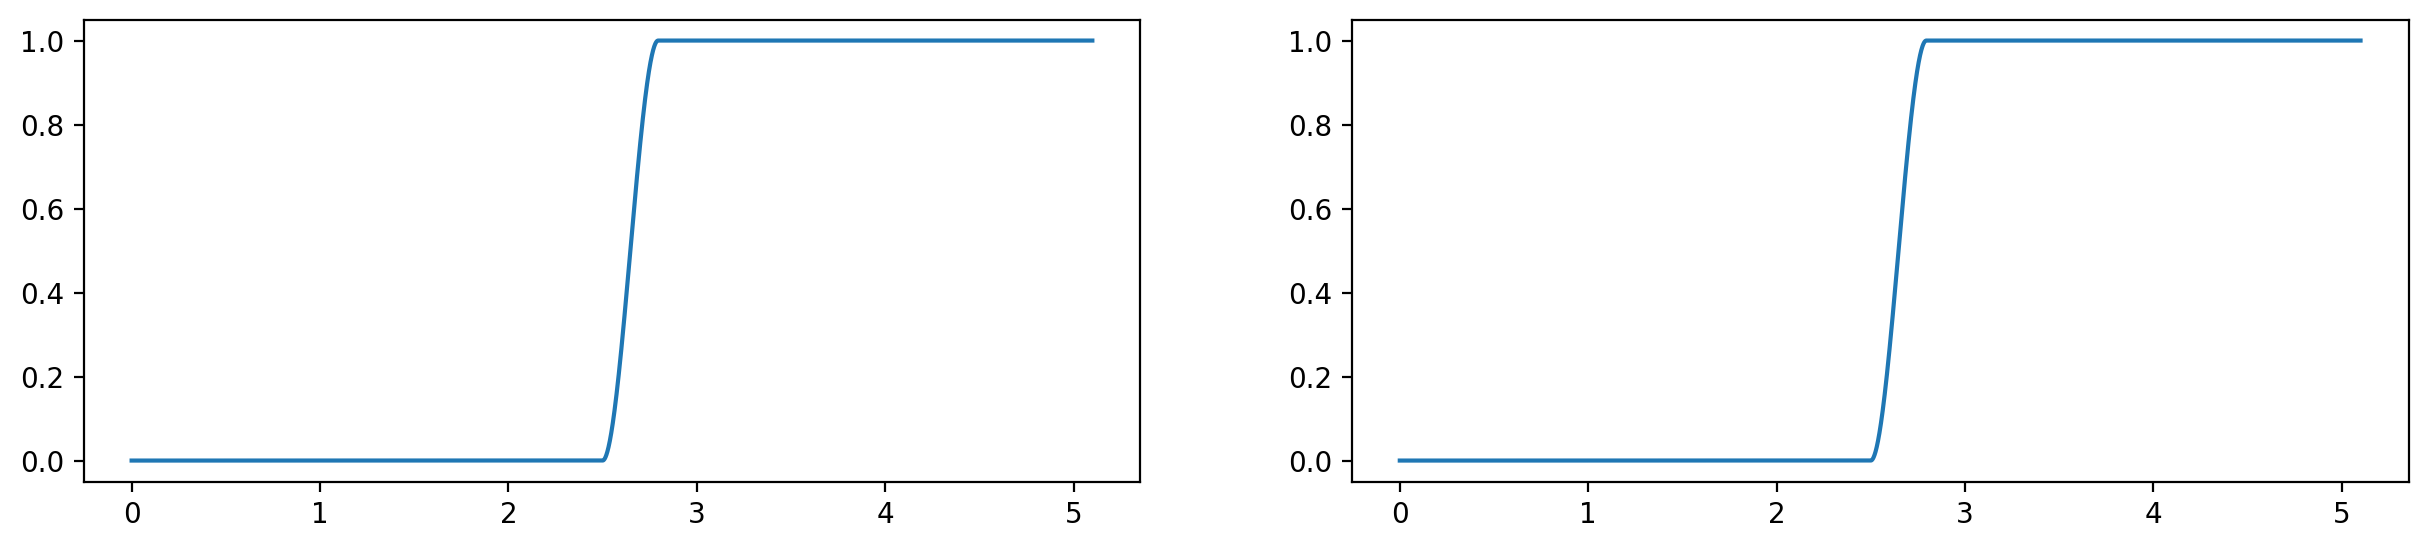

区间[2.50,3.75]的训练时间：10.68 min(s)
Final loss: 9.57110e-05,Total iteration: 13949

查看区间：[2.50,3.75]

Relative L2 error_u: 1.84006e-02

Relative L1 error_u: 1.15013e-02

Relative Linf error_u: 2.48002e-02
训练区间：[3.75,5.00]
p的初始化：4.375e+00 

	====Begin Adam====
1000,p:4.05e+00,weight0:1.00e+00,loss:1.52068e+01,i:0.00e+00,f:1.52e+01,b:4.56e-03
2000,p:3.92e+00,weight0:1.00e+00,loss:6.62434e-01,i:0.00e+00,f:6.54e-01,b:8.54e-03
3000,p:3.91e+00,weight0:1.00e+00,loss:1.88040e-01,i:0.00e+00,f:1.79e-01,b:8.93e-03
4000,p:3.90e+00,weight0:1.00e+00,loss:1.11334e-01,i:0.00e+00,f:1.03e-01,b:7.85e-03
5000,p:3.90e+00,weight0:1.00e+00,loss:7.77402e-02,i:0.00e+00,f:7.04e-02,b:7.31e-03

	====Begin LBFSG====
6000,p:3.88e+00,weight0:1.00e+00,loss:1.83383e-03,i:0.00e+00,f:1.77e-03,b:6.88e-05
7000,p:3.88e+00,weight0:1.00e+00,loss:4.74085e-04,i:0.00e+00,f:4.69e-04,b:5.54e-06
8000,p:3.88e+00,weight0:1.00e+00,loss:2.46224e-04,i:0.00e+00,f:2.45e-04,b:1.07e-06
9000,p:3.88e+00,weight0:1.00e+00,loss:1.58063e-04,i:0.00e+

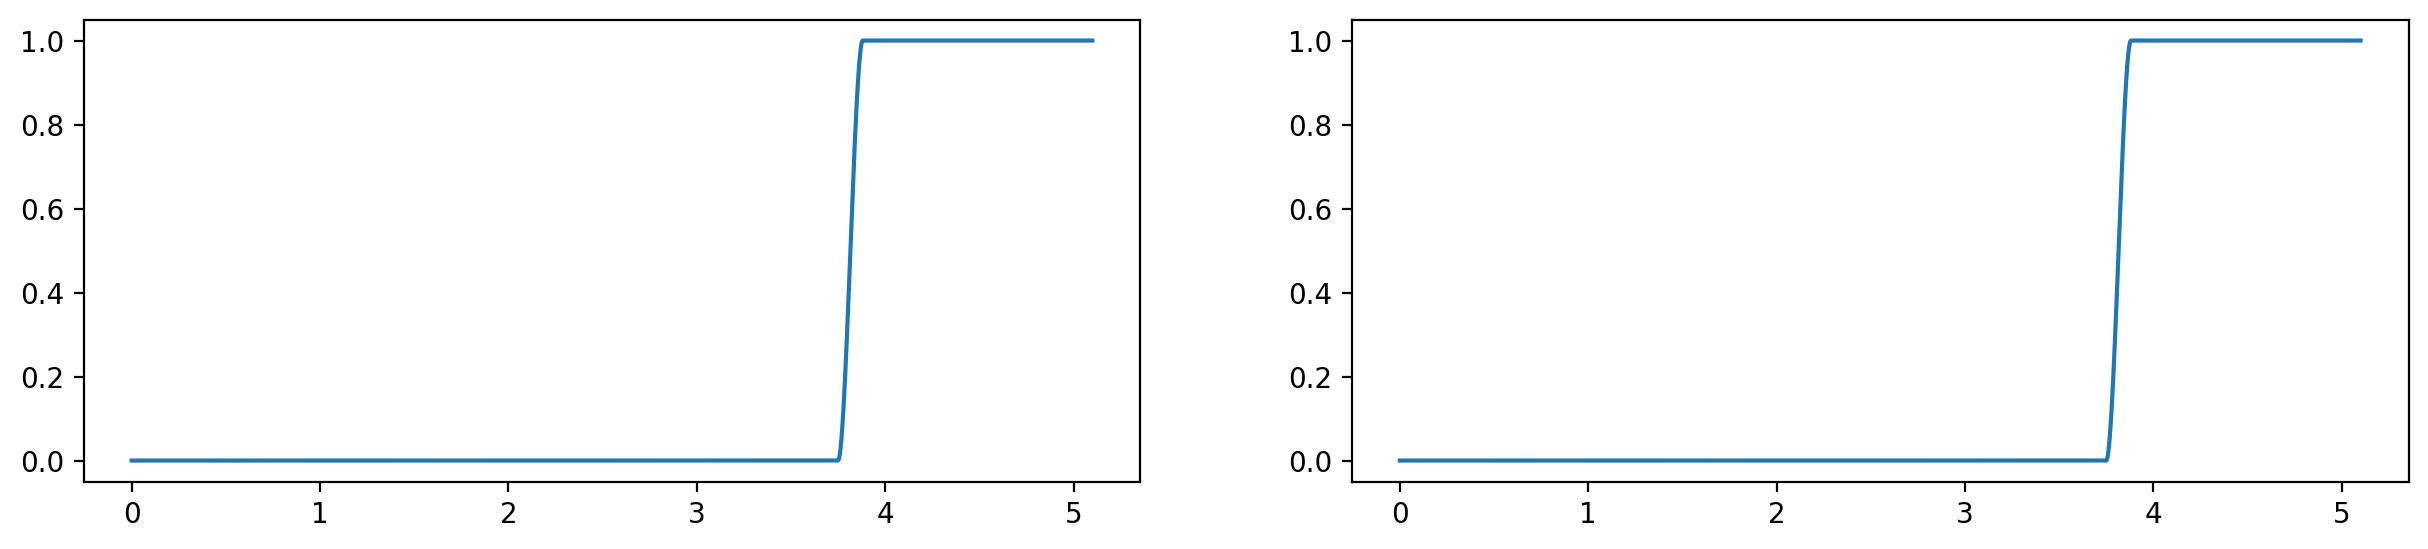

区间[3.75,5.00]的训练时间：9.22 min(s)
Final loss: 7.61221e-05,Total iteration: 11837

查看区间：[3.75,5.00]

Relative L2 error_u: 2.52257e-02

Relative L1 error_u: 1.60397e-02

Relative Linf error_u: 2.79531e-02

#小区间个数：4，总训练时长:38.46  min(s)

#查看区间[0.00,5.00]:
#error L2:1.66520e-02
#error L1:9.23615e-03
#error Linf:2.79531e-02
-----**区间个数：5, 第1次训练, 随机种子: 1156**-----
训练区间：[0.00,1.00]

	====Begin Adam====
1000,loss:4.85494e-01,i:4.69e-01,f:1.67e-02,b:1.72e-04
2000,loss:2.10620e-01,i:1.41e-01,f:2.25e-02,b:4.74e-02
3000,loss:7.46862e-02,i:2.71e-02,f:9.98e-03,b:3.76e-02
4000,loss:4.10838e-02,i:8.77e-03,f:5.66e-03,b:2.67e-02
5000,loss:3.15883e-02,i:4.67e-03,f:6.08e-03,b:2.08e-02

	====Begin LBFSG====
6000,loss:5.95836e-04,i:2.43e-06,f:5.46e-04,b:4.71e-05
7000,loss:7.96186e-05,i:1.07e-07,f:7.85e-05,b:9.63e-07
8000,loss:3.32544e-05,i:1.55e-08,f:3.27e-05,b:5.48e-07
9000,loss:1.66617e-05,i:1.25e-08,f:1.62e-05,b:4.09e-07
10000,loss:9.94725e-06,i:6.35e-09,f:9.76e-06,b:1.80e-07
11000,loss:6.98711e-06,i:8.81e-0

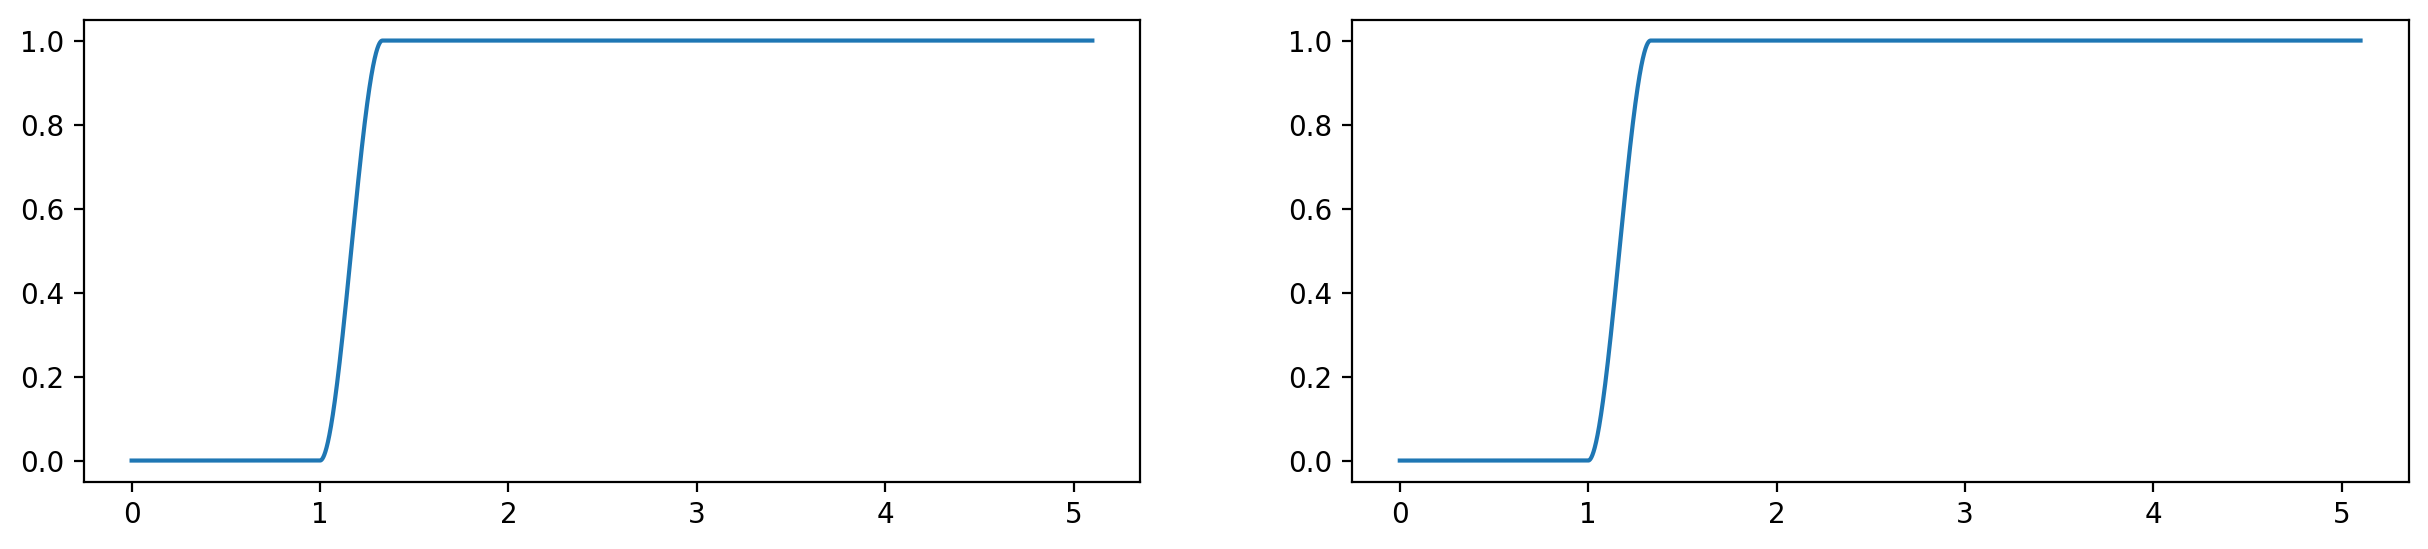

区间[1.00,2.00]的训练时间：15.75 min(s)
Final loss: 3.86695e-05,Total iteration: 14386

查看区间：[1.00,2.00]

Relative L2 error_u: 4.38898e-03

Relative L1 error_u: 2.73642e-03

Relative Linf error_u: 5.50377e-03
训练区间：[2.00,3.00]
p的初始化：2.500e+00 

	====Begin Adam====
1000,p:2.14e+00,weight0:1.00e+00,loss:1.21900e+00,i:0.00e+00,f:1.17e+00,b:5.37e-02
2000,p:2.13e+00,weight0:1.00e+00,loss:2.51921e-01,i:0.00e+00,f:1.86e-01,b:6.60e-02
3000,p:2.12e+00,weight0:1.00e+00,loss:1.60250e-01,i:0.00e+00,f:9.73e-02,b:6.30e-02
4000,p:2.12e+00,weight0:1.00e+00,loss:1.28182e-01,i:0.00e+00,f:6.95e-02,b:5.86e-02
5000,p:2.12e+00,weight0:1.00e+00,loss:1.09530e-01,i:0.00e+00,f:5.40e-02,b:5.56e-02

	====Begin LBFSG====
6000,p:2.11e+00,weight0:1.00e+00,loss:2.35236e-02,i:0.00e+00,f:5.80e-03,b:1.77e-02
7000,p:2.11e+00,weight0:1.00e+00,loss:4.68139e-03,i:0.00e+00,f:2.70e-03,b:1.98e-03
8000,p:2.11e+00,weight0:1.00e+00,loss:9.89993e-04,i:0.00e+00,f:9.59e-04,b:3.10e-05
9000,p:2.11e+00,weight0:1.00e+00,loss:5.18918e-04,i:0.00e+

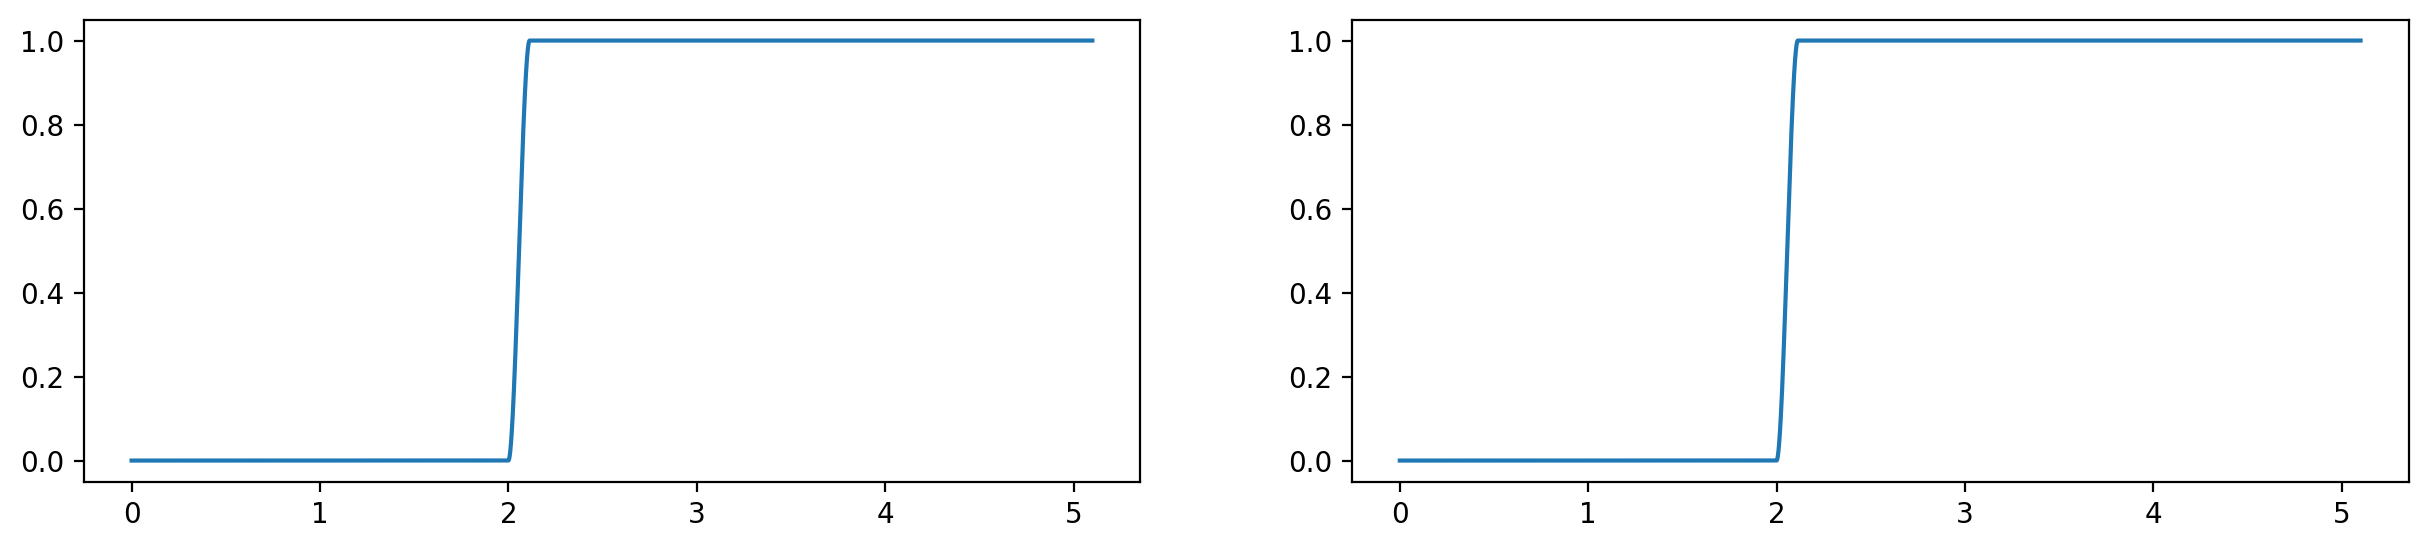

区间[2.00,3.00]的训练时间：15.64 min(s)
Final loss: 1.32086e-04,Total iteration: 14248

查看区间：[2.00,3.00]

Relative L2 error_u: 7.09154e-03

Relative L1 error_u: 4.45520e-03

Relative Linf error_u: 8.56555e-03
训练区间：[3.00,4.00]
p的初始化：3.500e+00 

	====Begin Adam====
1000,p:3.29e+00,weight0:1.00e+00,loss:2.00934e+00,i:0.00e+00,f:2.00e+00,b:7.11e-03
2000,p:3.24e+00,weight0:1.00e+00,loss:6.53046e-01,i:0.00e+00,f:6.33e-01,b:2.02e-02
3000,p:3.21e+00,weight0:1.00e+00,loss:1.58788e-01,i:0.00e+00,f:1.35e-01,b:2.33e-02
4000,p:3.19e+00,weight0:1.00e+00,loss:7.28002e-01,i:0.00e+00,f:7.08e-01,b:2.01e-02
5000,p:3.19e+00,weight0:1.00e+00,loss:4.68168e-02,i:0.00e+00,f:2.98e-02,b:1.70e-02

	====Begin LBFSG====
6000,p:3.17e+00,weight0:1.00e+00,loss:7.35805e-04,i:0.00e+00,f:6.99e-04,b:3.69e-05
7000,p:3.17e+00,weight0:1.00e+00,loss:1.85414e-04,i:0.00e+00,f:1.84e-04,b:1.55e-06
8000,p:3.17e+00,weight0:1.00e+00,loss:9.78824e-05,i:0.00e+00,f:9.74e-05,b:4.34e-07
9000,p:3.17e+00,weight0:1.00e+00,loss:7.25666e-05,i:0.00e+

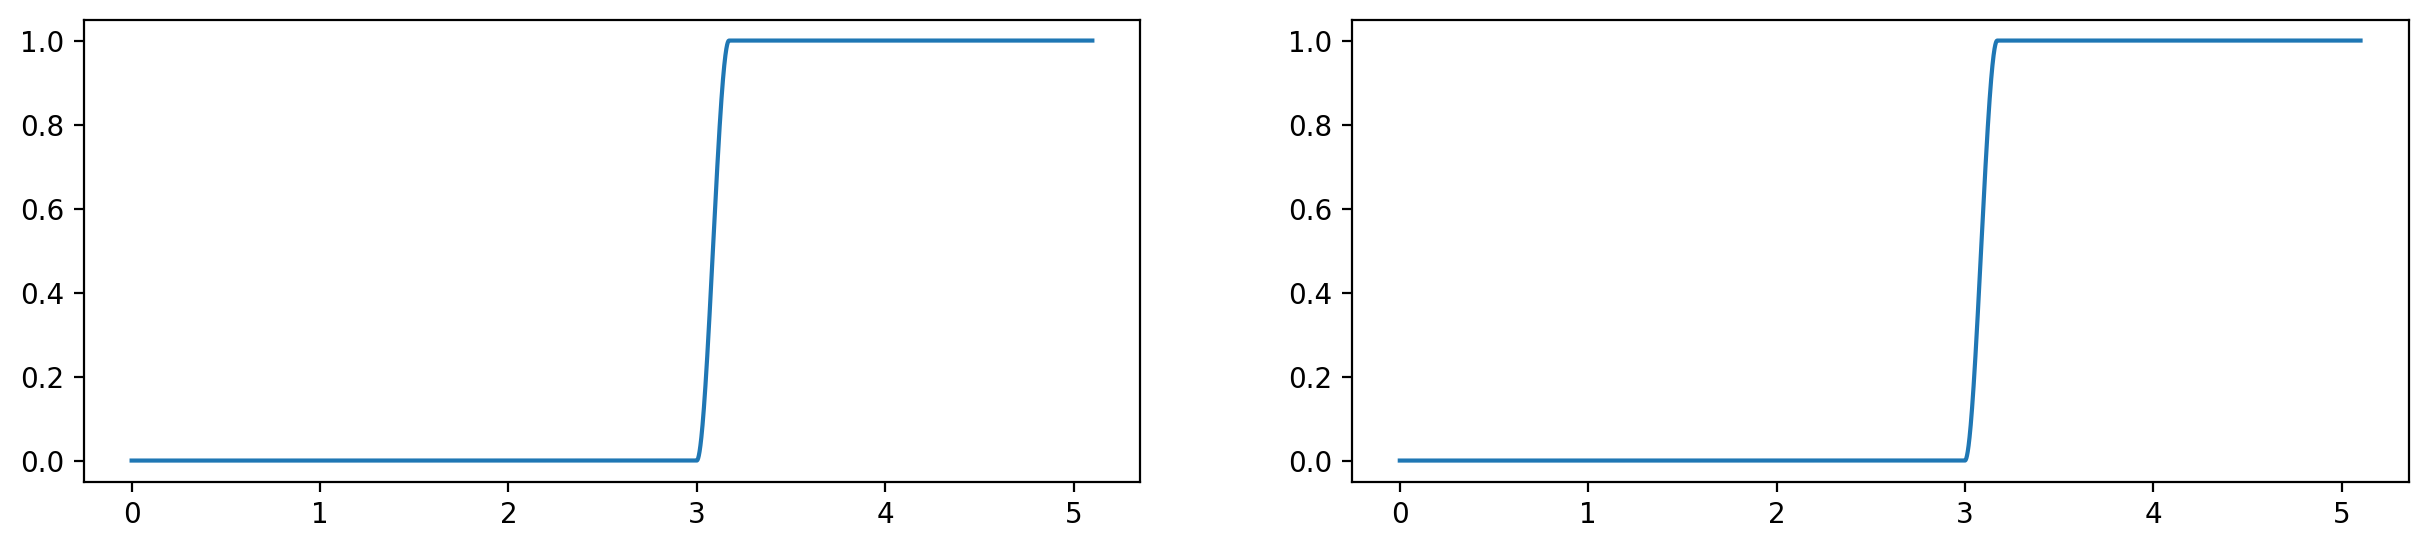

区间[3.00,4.00]的训练时间：10.89 min(s)
Final loss: 4.97629e-05,Total iteration: 10879

查看区间：[3.00,4.00]

Relative L2 error_u: 7.88875e-03

Relative L1 error_u: 4.96564e-03

Relative Linf error_u: 9.41730e-03
训练区间：[4.00,5.00]
p的初始化：4.500e+00 

	====Begin Adam====
1000,p:4.17e+00,weight0:1.00e+00,loss:1.01008e+00,i:0.00e+00,f:1.00e+00,b:9.87e-03
2000,p:4.15e+00,weight0:1.00e+00,loss:3.24749e-01,i:0.00e+00,f:3.00e-01,b:2.43e-02
3000,p:4.15e+00,weight0:1.00e+00,loss:1.41058e-01,i:0.00e+00,f:1.09e-01,b:3.21e-02
4000,p:4.15e+00,weight0:1.00e+00,loss:9.12559e-02,i:0.00e+00,f:5.97e-02,b:3.15e-02
5000,p:4.14e+00,weight0:1.00e+00,loss:6.99162e-02,i:0.00e+00,f:4.00e-02,b:2.99e-02

	====Begin LBFSG====
6000,p:4.12e+00,weight0:1.00e+00,loss:4.27149e-03,i:0.00e+00,f:2.66e-03,b:1.61e-03
7000,p:4.12e+00,weight0:1.00e+00,loss:5.38666e-04,i:0.00e+00,f:5.21e-04,b:1.76e-05
8000,p:4.12e+00,weight0:1.00e+00,loss:2.08417e-04,i:0.00e+00,f:2.01e-04,b:7.38e-06
9000,p:4.12e+00,weight0:1.00e+00,loss:1.27669e-04,i:0.00e+

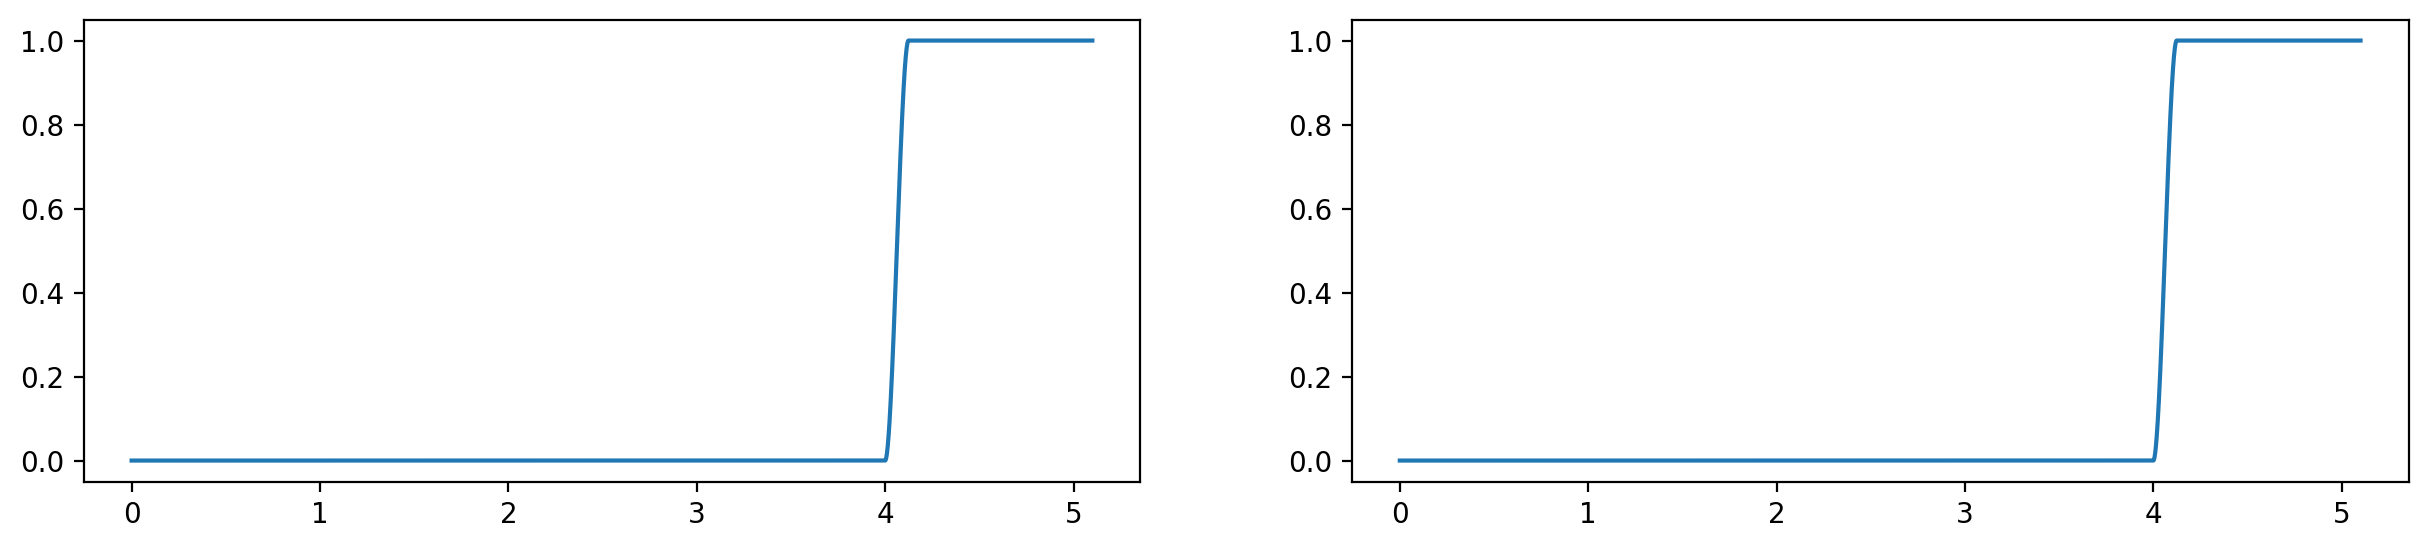

区间[4.00,5.00]的训练时间：10.10 min(s)
Final loss: 7.79146e-05,Total iteration: 10501

查看区间：[4.00,5.00]

Relative L2 error_u: 1.10897e-02

Relative L1 error_u: 6.87520e-03

Relative Linf error_u: 1.53661e-02

#小区间个数：5，总训练时长:61.99  min(s)

#查看区间[0.00,5.00]:
#error L2:7.17619e-03
#error L1:3.98514e-03
#error Linf:1.53661e-02
-----**区间个数：5, 第2次训练, 随机种子: 2834**-----
训练区间：[0.00,1.00]

	====Begin Adam====
1000,loss:4.89742e-01,i:4.86e-01,f:3.54e-03,b:1.51e-05
2000,loss:4.49626e-01,i:4.27e-01,f:2.20e-02,b:5.53e-04
3000,loss:1.42240e-01,i:7.84e-02,f:1.63e-02,b:4.76e-02
4000,loss:8.04224e-02,i:3.33e-02,f:9.39e-03,b:3.78e-02
5000,loss:5.87902e-02,i:1.97e-02,f:8.45e-03,b:3.06e-02

	====Begin LBFSG====
6000,loss:3.53436e-03,i:7.57e-05,f:1.97e-03,b:1.49e-03
7000,loss:6.58053e-04,i:5.49e-06,f:6.18e-04,b:3.44e-05
8000,loss:1.87940e-04,i:4.18e-07,f:1.84e-04,b:3.78e-06
9000,loss:7.96019e-05,i:4.27e-07,f:7.84e-05,b:7.75e-07
10000,loss:4.03352e-05,i:1.49e-07,f:3.98e-05,b:3.49e-07
区间[0.00,1.00]的训练时间：8.87 min(s)


区间[1.00,2.00]的训练时间：13.36 min(s)
Final loss: 8.03073e-05,Total iteration: 13486

查看区间：[1.00,2.00]

Relative L2 error_u: 6.18770e-03

Relative L1 error_u: 3.82167e-03

Relative Linf error_u: 7.88659e-03
训练区间：[2.00,3.00]
p的初始化：2.500e+00 

	====Begin Adam====
1000,p:2.15e+00,weight0:1.00e+00,loss:6.18773e-01,i:0.00e+00,f:5.81e-01,b:3.83e-02
2000,p:2.14e+00,weight0:1.00e+00,loss:1.19651e-01,i:0.00e+00,f:8.83e-02,b:3.14e-02
3000,p:2.13e+00,weight0:1.00e+00,loss:6.99821e-02,i:0.00e+00,f:4.28e-02,b:2.72e-02
4000,p:2.13e+00,weight0:1.00e+00,loss:6.06678e-02,i:0.00e+00,f:3.66e-02,b:2.41e-02
5000,p:2.13e+00,weight0:1.00e+00,loss:7.74718e-02,i:0.00e+00,f:5.58e-02,b:2.17e-02

	====Begin LBFSG====
6000,p:2.12e+00,weight0:1.00e+00,loss:1.72555e-03,i:0.00e+00,f:1.63e-03,b:9.19e-05
7000,p:2.12e+00,weight0:1.00e+00,loss:5.57079e-04,i:0.00e+00,f:5.47e-04,b:1.02e-05
8000,p:2.12e+00,weight0:1.00e+00,loss:3.32846e-04,i:0.00e+00,f:3.28e-04,b:4.95e-06
9000,p:2.12e+00,weight0:1.00e+00,loss:2.42171e-04,i:0.00e+

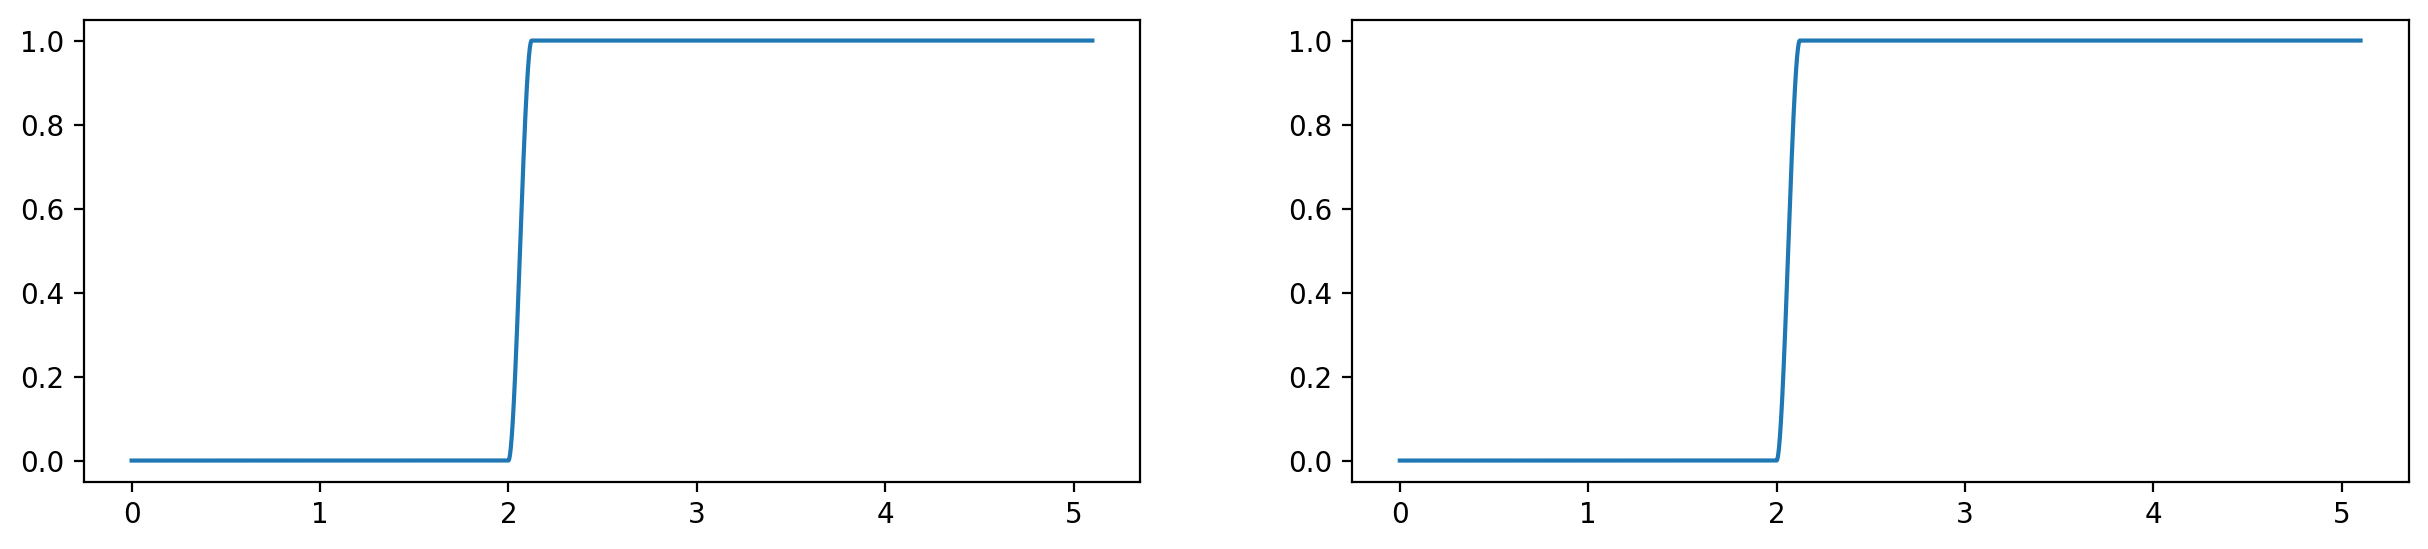

区间[2.00,3.00]的训练时间：12.83 min(s)
Final loss: 9.62093e-05,Total iteration: 14053

查看区间：[2.00,3.00]

Relative L2 error_u: 7.76917e-03

Relative L1 error_u: 4.88178e-03

Relative Linf error_u: 9.23419e-03
训练区间：[3.00,4.00]
p的初始化：3.500e+00 

	====Begin Adam====
1000,p:3.20e+00,weight0:1.00e+00,loss:5.54028e-01,i:0.00e+00,f:5.37e-01,b:1.73e-02
2000,p:3.19e+00,weight0:1.00e+00,loss:4.29159e-01,i:0.00e+00,f:4.10e-01,b:1.91e-02
3000,p:3.19e+00,weight0:1.00e+00,loss:1.02282e-01,i:0.00e+00,f:8.74e-02,b:1.49e-02
4000,p:3.18e+00,weight0:1.00e+00,loss:7.55459e-02,i:0.00e+00,f:6.21e-02,b:1.34e-02
5000,p:3.18e+00,weight0:1.00e+00,loss:4.93695e-02,i:0.00e+00,f:3.60e-02,b:1.34e-02

	====Begin LBFSG====
6000,p:3.17e+00,weight0:1.00e+00,loss:1.54768e-03,i:0.00e+00,f:1.52e-03,b:3.13e-05
7000,p:3.17e+00,weight0:1.00e+00,loss:5.46497e-04,i:0.00e+00,f:5.37e-04,b:9.83e-06
8000,p:3.17e+00,weight0:1.00e+00,loss:3.44580e-04,i:0.00e+00,f:3.42e-04,b:2.54e-06
9000,p:3.17e+00,weight0:1.00e+00,loss:2.50633e-04,i:0.00e+

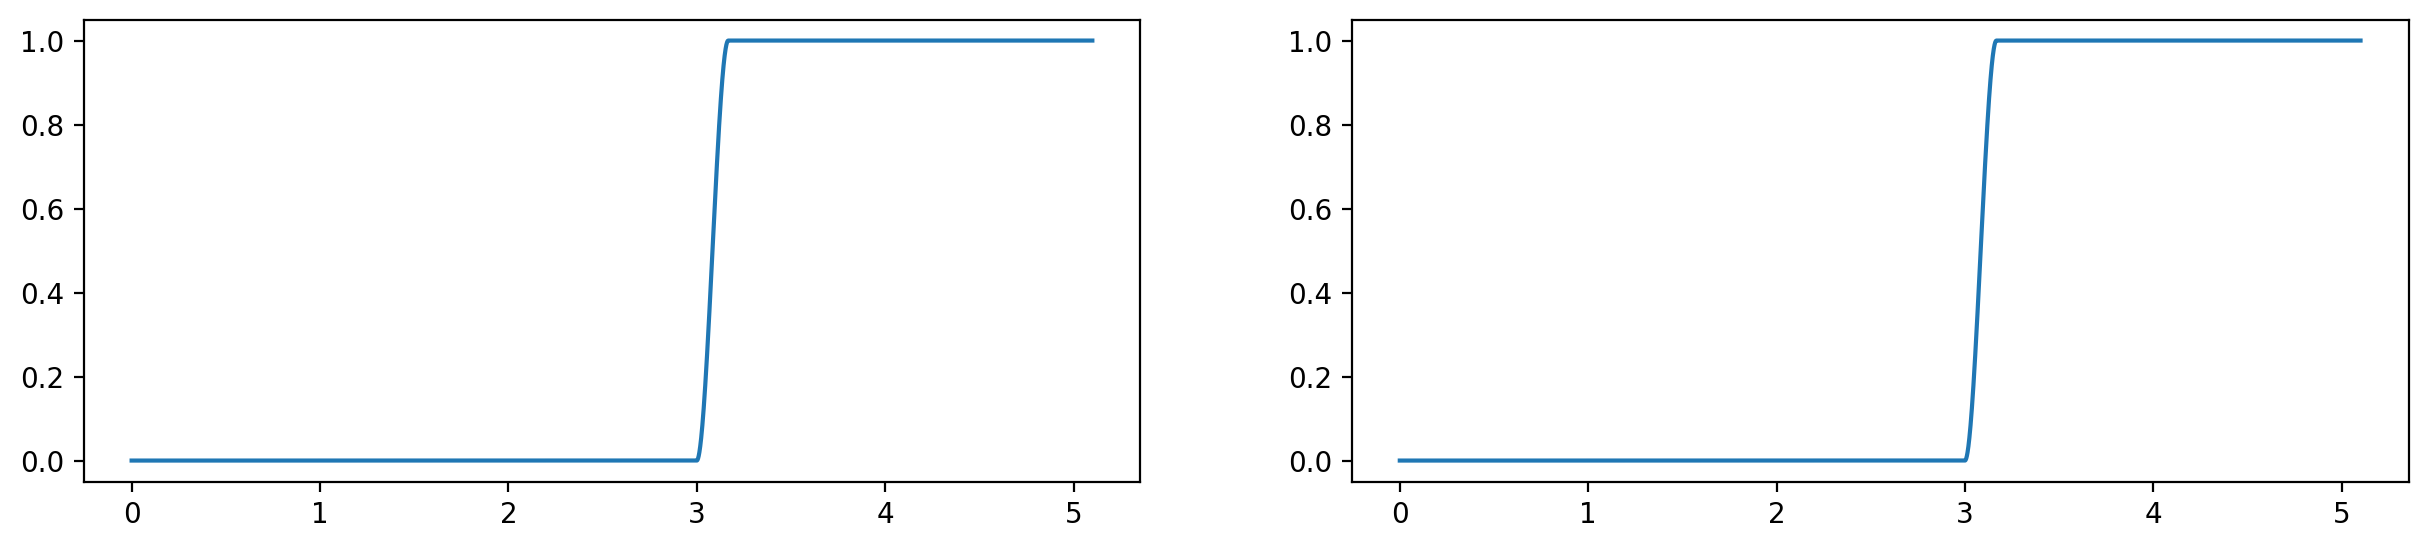

区间[3.00,4.00]的训练时间：11.43 min(s)
Final loss: 1.27174e-04,Total iteration: 12208

查看区间：[3.00,4.00]

Relative L2 error_u: 8.82903e-03

Relative L1 error_u: 5.58358e-03

Relative Linf error_u: 9.98712e-03
训练区间：[4.00,5.00]
p的初始化：4.500e+00 

	====Begin Adam====
1000,p:4.38e+00,weight0:1.00e+00,loss:6.90482e-01,i:0.00e+00,f:6.56e-01,b:3.46e-02
2000,p:4.36e+00,weight0:1.00e+00,loss:2.70877e-01,i:0.00e+00,f:2.48e-01,b:2.24e-02
3000,p:4.35e+00,weight0:1.00e+00,loss:1.74354e-01,i:0.00e+00,f:1.57e-01,b:1.71e-02
4000,p:4.35e+00,weight0:1.00e+00,loss:1.21214e-01,i:0.00e+00,f:1.07e-01,b:1.40e-02
5000,p:4.34e+00,weight0:1.00e+00,loss:1.17574e-01,i:0.00e+00,f:1.06e-01,b:1.19e-02

	====Begin LBFSG====
6000,p:4.29e+00,weight0:1.00e+00,loss:1.38522e-03,i:0.00e+00,f:1.32e-03,b:6.46e-05
7000,p:4.29e+00,weight0:1.00e+00,loss:3.95998e-04,i:0.00e+00,f:3.85e-04,b:1.12e-05
8000,p:4.29e+00,weight0:1.00e+00,loss:2.11722e-04,i:0.00e+00,f:2.05e-04,b:6.59e-06
9000,p:4.29e+00,weight0:1.00e+00,loss:1.41099e-04,i:0.00e+

区间[4.00,5.00]的训练时间：13.59 min(s)
Final loss: 5.19875e-05,Total iteration: 13747

查看区间：[4.00,5.00]

Relative L2 error_u: 9.90777e-03

Relative L1 error_u: 6.02432e-03

Relative Linf error_u: 1.31777e-02

#小区间个数：5，总训练时长:60.06  min(s)

#查看区间[0.00,5.00]:
#error L2:7.50607e-03
#error L1:4.34354e-03
#error Linf:1.31777e-02
-----**区间个数：5, 第3次训练, 随机种子: 2392**-----
训练区间：[0.00,1.00]

	====Begin Adam====
1000,loss:5.08990e-01,i:5.04e-01,f:4.81e-03,b:2.61e-05
2000,loss:4.89828e-01,i:4.76e-01,f:1.36e-02,b:1.83e-04
3000,loss:2.07922e-01,i:1.29e-01,f:2.36e-02,b:5.52e-02
4000,loss:9.64281e-02,i:3.91e-02,f:1.44e-02,b:4.29e-02
5000,loss:5.68573e-02,i:1.43e-02,f:9.09e-03,b:3.34e-02

	====Begin LBFSG====
6000,loss:1.33893e-03,i:9.27e-06,f:1.21e-03,b:1.21e-04
7000,loss:2.13765e-04,i:6.86e-07,f:2.11e-04,b:1.82e-06
8000,loss:7.08753e-05,i:3.66e-08,f:7.04e-05,b:4.39e-07
9000,loss:3.48567e-05,i:1.95e-08,f:3.48e-05,b:4.41e-08
10000,loss:1.92045e-05,i:2.49e-08,f:1.91e-05,b:8.84e-08
区间[0.00,1.00]的训练时间：7.37 min(s)


区间[1.00,2.00]的训练时间：10.17 min(s)
Final loss: 9.38824e-05,Total iteration: 11489

查看区间：[1.00,2.00]

Relative L2 error_u: 3.27840e-03

Relative L1 error_u: 1.95755e-03

Relative Linf error_u: 4.69685e-03
训练区间：[2.00,3.00]
p的初始化：2.500e+00 

	====Begin Adam====
1000,p:2.21e+00,weight0:1.00e+00,loss:7.51150e-01,i:0.00e+00,f:7.35e-01,b:1.66e-02
2000,p:2.20e+00,weight0:1.00e+00,loss:1.91323e-01,i:0.00e+00,f:1.70e-01,b:2.14e-02
3000,p:2.19e+00,weight0:1.00e+00,loss:9.07385e-02,i:0.00e+00,f:6.95e-02,b:2.13e-02
4000,p:2.19e+00,weight0:1.00e+00,loss:3.95246e-01,i:0.00e+00,f:3.76e-01,b:1.96e-02
5000,p:2.19e+00,weight0:1.00e+00,loss:5.49213e-02,i:0.00e+00,f:3.64e-02,b:1.86e-02

	====Begin LBFSG====
6000,p:2.17e+00,weight0:1.00e+00,loss:1.38800e-03,i:0.00e+00,f:1.26e-03,b:1.32e-04
7000,p:2.17e+00,weight0:1.00e+00,loss:3.12758e-04,i:0.00e+00,f:3.05e-04,b:7.73e-06
8000,p:2.17e+00,weight0:1.00e+00,loss:1.58939e-04,i:0.00e+00,f:1.57e-04,b:2.28e-06
9000,p:2.17e+00,weight0:1.00e+00,loss:1.07168e-04,i:0.00e+

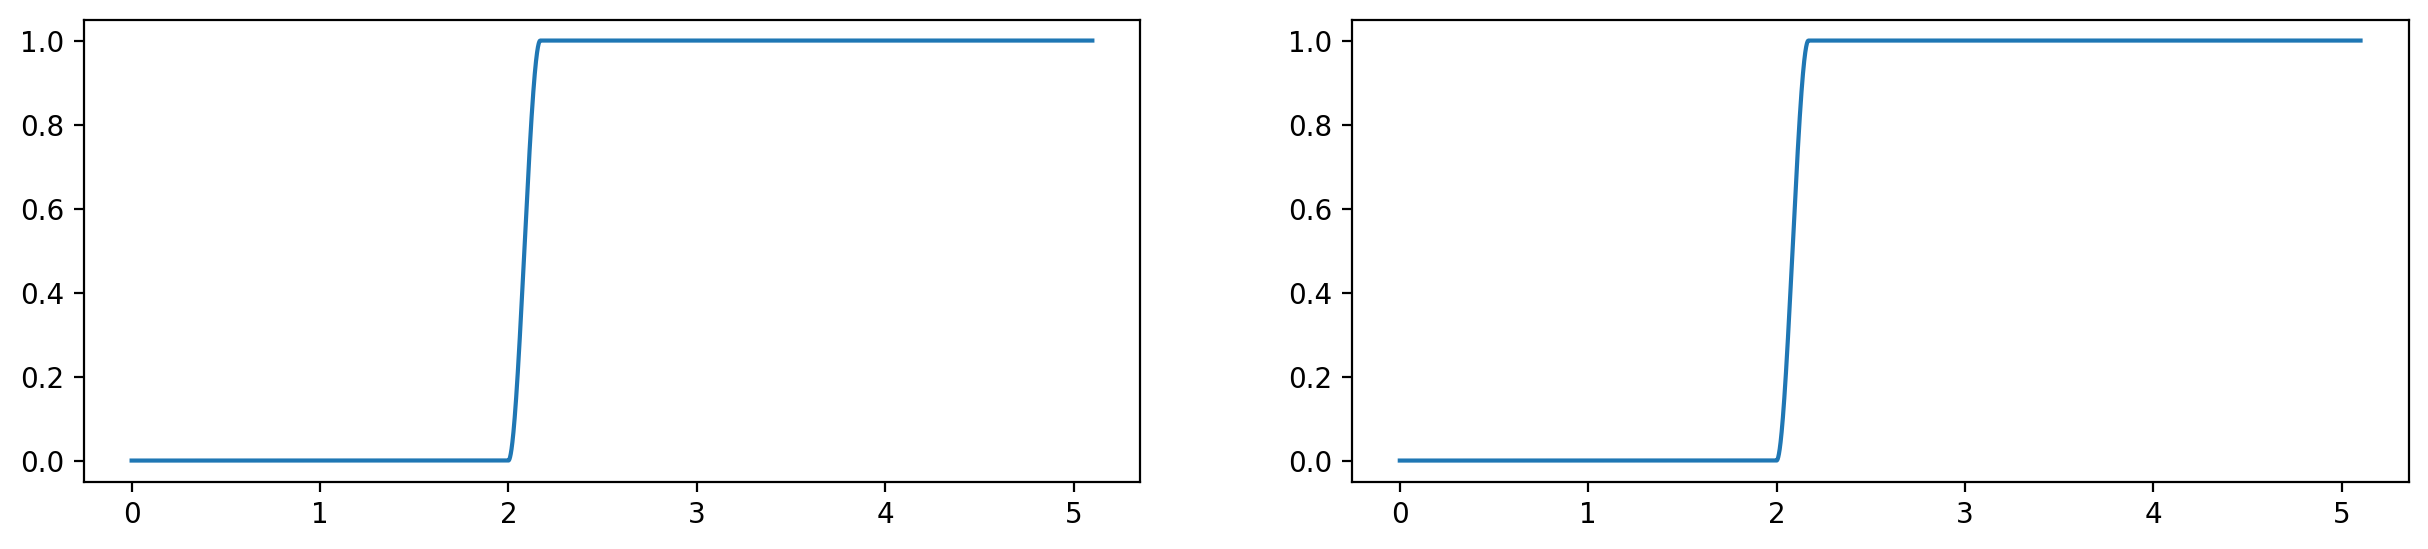

区间[2.00,3.00]的训练时间：10.14 min(s)
Final loss: 6.84751e-05,Total iteration: 11460

查看区间：[2.00,3.00]

Relative L2 error_u: 4.93756e-03

Relative L1 error_u: 3.09253e-03

Relative Linf error_u: 6.29175e-03
训练区间：[3.00,4.00]
p的初始化：3.500e+00 

	====Begin Adam====
1000,p:3.25e+00,weight0:1.00e+00,loss:8.21377e-01,i:0.00e+00,f:8.08e-01,b:1.34e-02
2000,p:3.23e+00,weight0:1.00e+00,loss:2.70196e-01,i:0.00e+00,f:2.54e-01,b:1.57e-02
3000,p:3.22e+00,weight0:1.00e+00,loss:1.02099e-01,i:0.00e+00,f:8.62e-02,b:1.59e-02
4000,p:3.21e+00,weight0:1.00e+00,loss:5.68895e-02,i:0.00e+00,f:4.23e-02,b:1.46e-02
5000,p:3.20e+00,weight0:1.00e+00,loss:3.92263e-02,i:0.00e+00,f:2.57e-02,b:1.35e-02

	====Begin LBFSG====
6000,p:3.19e+00,weight0:1.00e+00,loss:1.03200e-03,i:0.00e+00,f:1.01e-03,b:2.10e-05
7000,p:3.19e+00,weight0:1.00e+00,loss:2.68583e-04,i:0.00e+00,f:2.64e-04,b:4.20e-06
8000,p:3.18e+00,weight0:1.00e+00,loss:1.47657e-04,i:0.00e+00,f:1.45e-04,b:2.63e-06
9000,p:3.18e+00,weight0:1.00e+00,loss:1.04892e-04,i:0.00e+

区间[3.00,4.00]的训练时间：10.42 min(s)
Final loss: 6.12936e-05,Total iteration: 11469

查看区间：[3.00,4.00]

Relative L2 error_u: 4.16949e-03

Relative L1 error_u: 2.54298e-03

Relative Linf error_u: 6.12718e-03
训练区间：[4.00,5.00]
p的初始化：4.500e+00 

	====Begin Adam====
1000,p:4.22e+00,weight0:1.00e+00,loss:1.65110e+00,i:0.00e+00,f:1.63e+00,b:1.75e-02
2000,p:4.20e+00,weight0:1.00e+00,loss:8.59942e-01,i:0.00e+00,f:8.14e-01,b:4.58e-02
3000,p:4.19e+00,weight0:1.00e+00,loss:1.91056e-01,i:0.00e+00,f:1.41e-01,b:4.96e-02
4000,p:4.19e+00,weight0:1.00e+00,loss:1.20179e-01,i:0.00e+00,f:7.37e-02,b:4.64e-02
5000,p:4.19e+00,weight0:1.00e+00,loss:9.12375e-02,i:0.00e+00,f:4.92e-02,b:4.21e-02

	====Begin LBFSG====
6000,p:4.18e+00,weight0:1.00e+00,loss:2.44371e-03,i:0.00e+00,f:2.06e-03,b:3.82e-04
7000,p:4.18e+00,weight0:1.00e+00,loss:4.84759e-04,i:0.00e+00,f:4.76e-04,b:9.06e-06
8000,p:4.18e+00,weight0:1.00e+00,loss:2.11373e-04,i:0.00e+00,f:2.07e-04,b:3.91e-06
9000,p:4.18e+00,weight0:1.00e+00,loss:1.38951e-04,i:0.00e+

区间[4.00,5.00]的训练时间：10.37 min(s)
Final loss: 7.94961e-05,Total iteration: 11386

查看区间：[4.00,5.00]

Relative L2 error_u: 7.95073e-03

Relative L1 error_u: 4.68525e-03

Relative Linf error_u: 1.15760e-02

#小区间个数：5，总训练时长:48.46  min(s)

#查看区间[0.00,5.00]:
#error L2:4.83124e-03
#error L1:2.55694e-03
#error Linf:1.15760e-02


In [9]:





with pd.ExcelWriter(folder_path + '/error.xlsx', engine='openpyxl') as writer:
    for num in range(num_block_start, num_block_end + 1):  # 对每一个训练的区间
        
        Random_seed_log = []
        error_for_train = []  # 用于记录不同区间的总误差
        for train in range(1, train_times + 1):
            
            Random_seed = random.randint(1, 1000 * train_times)
            Random_seed_log.append(Random_seed)
            setup_seed(Random_seed)
            print('-----**区间个数：%d, 第%d次训练, 随机种子: %d**-----' % (num, train, Random_seed))
            
           
            # 训练模型
            models, error_block, train_time = train_block(t_min, t_max, num, train)
            
            # 全区间预测
            u_pred, error_whole = u_pred_whole(models, t_min, t_max, num, train)

        

            # 完整误差记录
            error_block.append(error_whole)
            error_for_train.append(error_block)
            error_for_train.append(train_time)

        error_result = np.column_stack(error_for_train)
        
        # 保存结果
        column_names = [
            f"{Random_seed_log[group_num-1]}_{group_num}_{names[col_num]}"   
            for group_num in range(1, train_times + 1)
            for col_num in range(0, 4)
        ]
        
        index_names = [f'[{t_max * i / num},{t_max * (i + 1) / num}]' for i in range(num + 1)]
        index_names[-1] = f'[{t_min},{t_max}]'
        df1 = pd.DataFrame(error_result, index=index_names, columns=column_names)
        df1.to_excel(writer, sheet_name=f'Sheet_{num}', index=True)






